![title](img/banner.jpeg)

# Lyrix
## Semester project - Report
<b> Olivier Couque & Emma Lejal Glaude <br>
Supervisor: Panayotis Smeros, Lab: LSIR </b><br>

The goal of this project is to merge lyrics from two different music genres. In this notebook, we will guide you through our exploration and the different decisions we made to achieve as best as possible this goal.<br><br>

Here are the main parts of our work, you can directly go to the one you prefer:
1. [Data Gathering](#data)
2. [Data Cleaning](#cleaning)
3. [Preprocessing](#process)
4. [MUSE](#muse)
5. [Neural Network](#nn)
6. [Webpage](#webpage)
7. [Conclusion](#ccl)

<a id="top"></a>

### Litterature

To succeed in this project, we started by searching online to see if any similar projects existed. We found the following sources, approaching the frame of our project:
- A project generating rap lyrics based on all the Kanye West discography (https://github.com/robbiebarrat/rapping-neural-network)
- A project similar to the previous one with the choice of 5 different artists: Tupac, The Beatles, Kanye West, Taylor Swift and Drake (http://www.encore.ai)
- This project provides a web parser to gather the lyrics from given artists and predict lyrics from this data (https://github.com/tonybeltramelli/Deep-Lyrics)
- This page generates a rap punchline from the seed the user provides (https://raplyrics.eu)

We encourage you to visit the links and explore the kind of results they achieved.

[Go to top](#top)

<a id="data"></a>

We used many libraries throughout our work, you can find them all below. If you are not interested in the entire notebook, you can comment the parts not necessary.

In [1]:
#Usefull imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import pickle
import string
import json
import random
import csv
from collections import Counter

#Data Gathering Part
import requests
from bs4 import BeautifulSoup
import spotipy
import spotipy.oauth2 as oauth2
import spotipy.util as util

#Data Cleaning Part
from langdetect import detect

#Preprocessing Part
import sys
import codecs

#MUSE Part
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import norm
import matplotlib.mlab as mlab
from sklearn.neighbors import NearestNeighbors
import copy

#Neural Net Part
from nltk.corpus import words
# If needed to download package word, uncomment next 2 lines
#import nltk
#nltk.download('words')
import pyphen
import spacy
# Keras imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from scipy import sparse
from IPython.display import Markdown, display

Using TensorFlow backend.


## Data Gathering

The first step of this project was to gather a database of lyrics together with their music genre. The quality of this database is determinant to the quality of the results, therefore it is important to spend some time to find the best data possible. However we quickly realised that we would not find such a database available directly on the internet, for the following reasons:
- First we need complete lyrics and not only the bag of words contained in the lyrics. Indeed we need the ordering of words in order to predict which one could be next. However, this is difficult to get as the lyrics are protected by Intellectual Property. Consequently there are no open database with entire lyrics available. 
- We also need the lyrics classified according with the different musical genres. We rarely saw this information with the lyrics. The metadata available was often limited to the author/group, year, title, album.

As example of the previous points, we will give the following datasets: the <b>One Million Song Dataset</b>, unfortunately, this dataset contains only the bag of words and the <b>MusicBrainz</b> dataset having the lyrics in order but realized we could only get about a third of the lyrics per song. <br>
Our next move was to turn towards the Kaggle website, commonly known to provide good datasets for Machine Learning projects, to look for datasets and found the following one: https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics <br>
We decided to use it as a basis to start our work, below you will discover our use of this dataset.

Starting from here, all the files we load are available in a zip file named <b>data</b>. You can download it from this link : https://tinyurl.com/lyrix-data-zip

In [2]:
#Load the file
filepath = 'data/lyrics.csv'
lyrics_df = pd.read_csv(filepath)
lyrics_df.set_index('index', inplace = True)

In [3]:
#Inspect the content
print("Number of songs: {}".format(len(lyrics_df)))
lyrics_df.head()

Number of songs: 362237


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


Some songs have no lyrics availaible, as there are of no use for this project, we remove them.

In [4]:
lyrics_df.dropna(axis = 'index', subset = ['lyrics'], inplace = True)
print("Number of songs WITH available lyrics: {}".format(len(lyrics_df)))

Number of songs WITH available lyrics: 266557


In order to learn about the type of lyrics available in this dataset, we will gather the list of artists and genres. Once we have this we can learn about the distribution of genres.

In [5]:
artists = set(lyrics_df["artist"])
genres = set(lyrics_df["genre"])

print("Genres: {}".format(genres))
print("Number of artists: {}".format(len(artists)))

Genres: {'Folk', 'Jazz', 'Indie', 'Not Available', 'Country', 'Other', 'Hip-Hop', 'Electronic', 'Rock', 'Pop', 'Metal', 'R&B'}
Number of artists: 14543


In [6]:
songs_per_genre = {}
total_songs = 0
unknown_songs = 0
for genre in genres:
    nb = len(lyrics_df[lyrics_df['genre'] == genre])
    songs_per_genre[genre] = nb
    total_songs += nb
    if genre == "Not Available" or genre == "Other":
        unknown_songs += nb
songs_per_genre

{'Folk': 2243,
 'Jazz': 7971,
 'Indie': 3149,
 'Not Available': 23941,
 'Country': 14387,
 'Other': 5189,
 'Hip-Hop': 24850,
 'Electronic': 7966,
 'Rock': 109235,
 'Pop': 40466,
 'Metal': 23759,
 'R&B': 3401}

While querying some random songs and artists to learn about the dataset we realised that the dataset contained non-english songs. We decided to focus on English songs in this project as it seems that we will have more data and natural language processing libraries are often trained and optimised for the English language.<br>
We use the <b>detect</b> library to detect the main language of each song and remove the songs that are detected as NOT English. Note that this library isn't perfect and will predict as English some French or Spanish songs for instance. So we might find some of non English songs or words in the rest of the project. Making sure that all songs are in English could be an improvement of the project.

In [125]:
def language_of_lyrics(lyrics):
    try:
        lang = detect(lyrics)
        return lang
    except:
        return "no lang"

# RUNNING THIS CELL TAKES SOME TIMES SO WE SAVED THE LANGUAGE IN THE FILE lyrics_with_lang.csv (See cell below)
list_langs = []
for i, row in lyrics_df.iterrows():
    if i % 1000 == 0:
        print(i)
    lang = language_of_lyrics(row['lyrics'])
    list_langs.append(lang)

lyrics_df['language'] = list_langs

In [14]:
#We can now extract the english-identified songs
english_df = lyrics_df[lyrics_df['language'] == 'en']
print(len(english_df))
# Save in file
english_df.to_csv("data/en_lyrics.csv", index=False)
english_df.head()

238213


,song,year,artist,genre,lyrics,language
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...",en
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...",en
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,en
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...",en
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",en


As it happens this dataset does not contain the music genre for every song. In order to fill this information and reduce the number of songs in the 'Not Available' category (currently 23941), we will identify the main genre of each artist thanks to the Spotify API.<br>

We will then be able to have a look at the distribution of the lyrics.

In [7]:
#Spotify credentials and access token required to use the API
client_id = "c829ff34022d4c3a9e65c30c10623765"
client_secret = "8e998357ebf04fe092edab4915946e00"
credentials = oauth2.SpotifyClientCredentials(client_id, client_secret)
token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

In [8]:
filepath = "data/mb_music.csv" #we use a file from MusicBrainz to gather artists names
lyrics_df = pd.read_csv(filepath)
useful_df = lyrics_df[['artist.name', 'terms']]
useful_df.head()

,artist.name,terms
0,Casual,hip hop
1,The Box Tops,blue-eyed soul
2,Sonora Santanera,salsa
3,Adam Ant,pop rock
4,Gob,pop punk


From the dump of MusicBrainz dataset we gathered the file named 'artist'. To process the file and get the 'en_artists_from_musicbrainz', we made a list of all the artist names and apply the <b>detect</b> library to filter the non-English names. The idea was to get rid of the cyrillic or asian names, recognizable with the alphabet used.

In [9]:
with open ('data/en_artists_from_musicbrainz', 'rb') as fp:
    english_artist = pickle.load(fp)

In [10]:
print("Number of English artists found: ", len(english_artist))

365691

In [11]:
#Function using the Spotify API (need credentials)
def get_artist_genres(artist_name):
    """ Fetch on Spotify the genres of the artist"""
    query = sp.search(q='artist:' + artist_name, type='artist')
    if len(query['artists']['items']) > 0:
        genres = query['artists']['items'][0]['genres'] #eg list: ["pop rock", "hard rock", "alternative rock"...]
        return genres
    else:
        #print("{} not on Spotify".format(artist_name))
        return []

In [12]:
def refresh_token():
    """Reload the access token if it's outdated"""
    token = credentials.get_access_token()
    sp = spotipy.Spotify(auth=token)

Fetch genres for all artists of the file:

In [ ]:
#Warning : time consuming cell
artist_genre = []
artists = english_artist
artists_with_error = []

start = time.time()
print("Initial number of artists: {}".format(len(artists)))
for i, artist in enumerate(artists):
    if i % 500 == 0:
        print(i)
    if (time.time() - start)>= 3600: #Need to refresh the access token every hour (3600 seconds)
        start = time.time()
        refresh_token()
    try:
        genres = get_artist_genres(artist)
        if len(genres) > 0:
            artist_genre.append([artist, genres])
    except :
        artists_with_error.append(artist)
        #print("error for artist : ", artist)
print("Number of artists with genres on Spotify: {}".format(len(artist_genre)))

In [ ]:
#We can now create a simple dataframe with every artist linked to the music genre
artist_genres_df = pd.DataFrame(artist_genre, columns = {'artist', 'genre'})
artist_genres_df = artist_genres_df.drop_duplicates('artist')
artist_genres_df.to_csv("data/artist_genre.csv", sep=';')

As seen in the example above, Spotify can give a list of several genres to one artist. If this is very precise, it is not helpfull for our project, we will therefore define a list of main genres. This list is composed of pop, rock, metal, hip hop, jazz and country. <br>
Then we will match each artist to one genre from the MAIN_GENRES list. Typically, The Black Eyed Peas is characterized by genres: 'dance pop', 'pop', 'pop rap', as there is a majority of 'pop' appearing, we would associate The Black Eyed Peas to the 'pop' genre.

In [28]:
MAIN_GENRES = {'metal', 'hip hop', 'country', 'jazz', 'pop', 'rock'}

artist_path = "data/artist_genre.csv"
artist_genres_df = pd.read_csv(artist_path, sep = ';', usecols = ["artist", "genre"])
artist_genres_df.head() #Caution: The genre field is a string and not a list

,artist,genre
0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']"
1,Jimmy Hughes,['southern soul']
2,Joy Division,"['alternative rock', 'art rock', 'dance rock',..."
3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '..."
4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk..."


In [29]:
def get_main_genre(genres, main_genres = MAIN_GENRES):
    """ Count occurences of main genres terms in the genres string using regex"""
    main_genres_occ = [(g, len(re.findall(g, genres))) for g in main_genres if len(re.findall(g, genres)) > 0] 
    # list: [(rock, 3), (pop, 1), (hard, 1)...]
    
    if len(main_genres_occ) > 0:
        max_genre = sorted(main_genres_occ, key = lambda x: x[1], reverse = True)[0][0]
        return max_genre
    else:
        return "No main genre"

In [30]:
#Apply the simplification of genres to each artist
simple_genres = []
for i, artist_row in artist_genres_df.iterrows():
    genres = artist_row['genre']
    main_genre = get_main_genre(genres)
    simple_genres.append(main_genre)

col_name = "main genre"
if col_name in list(artist_genres_df.columns):
    artist_genres_df.drop(col_name, inplace = True)
artist_genres_df[col_name] = simple_genres
artist_genres_df.head()

,artist,genre,main genre
0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']",pop
1,Jimmy Hughes,['southern soul'],No main genre
2,Joy Division,"['alternative rock', 'art rock', 'dance rock',...",rock
3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '...",pop
4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk...",No main genre


In [31]:
#Check if we managed to clear the lists
set(artist_genres_df['main genre'])

{'No main genre', 'country', 'hip hop', 'jazz', 'metal', 'pop', 'rock'}

In [34]:
# Save the dataframe with main genre in a csv file
artist_genres_df = artist_genres_df[["artist", "main genre"]]
#artist_genres_df.to_csv("data/artists_main_genre.csv", index = False)

In [35]:
artist_genres_df = pd.read_csv("data/artists_main_genre.csv")

We can now analyse the artist distribution per genre in our dataset:

Number of artists: 2727
Number of artists with main genre: 1748
Ratio: 0.64


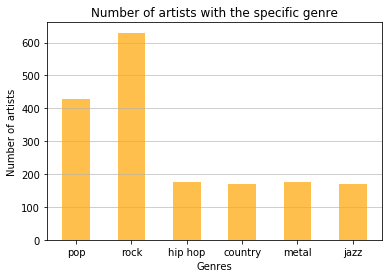

In [36]:
print("Number of artists: {}".format(len(artist_genres_df)))
#Delete the artist for whom we could not identify a main genre
genres_df = artist_genres_df[artist_genres_df["main genre"] != "No main genre"]
print("Number of artists with main genre: {}".format(len(genres_df)))
print("Ratio: {}".format(round(len(genres_df) / len(artist_genres_df), 2)))

n, bins, patches = plt.hist(list(genres_df["main genre"]), bins=np.arange(0,len(MAIN_GENRES) + 1), align='left', alpha=0.7, rwidth=0.5, color='orange')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of artists')
plt.title('Number of artists with the specific genre')
plt.show()

We can see here that pop and rock are considerably more represented.

In [46]:
english_df = pd.read_csv("data/en_lyrics.csv")
artist_genre_df = pd.read_csv("data/artists_main_genre.csv")
artist_genre_df.head()

,artist,main genre
0,Black Eyed Peas,pop
1,Jimmy Hughes,No main genre
2,Joy Division,rock
3,Mint Condition,pop
4,Plump DJs,No main genre


Let's recap the genre repartition in our Kaggle dataset.

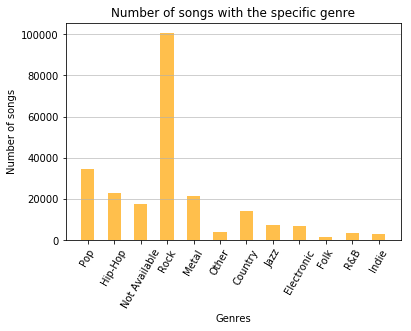

In [38]:
n, bins, patches = plt.hist(x = list(english_df["genre"]), bins=np.arange(0,len(set(english_df["genre"])) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of songs')
plt.title('Number of songs with the specific genre')
plt.xticks(rotation=60)
plt.show()

From this graph, we concluded that we had enough songs for the rock genre but not enough for the other main genres: pop, metal, jazz, hip hop, country. <br>
We therefore sought other methods to complete the dataset with other songs and have a more even distribution. The first idea was to use the artists we identified.

In [41]:
main_lyrics_df = english_df[english_df['genre'].isin(MAIN_GENRES)]
print("Ratio of lyrics kept from main genres: {}".format(len(main_lyrics_df) / len(english_df)))

# Give same format of artist names in both dataframes:
#eg. beyonce-knowles -> beyonce knowles
main_lyrics_df['artist'] = main_lyrics_df['artist'].apply(lambda a: a.replace('-', ' ').lower()) 
artist_genre_df['artist'] = artist_genre_df['artist'].apply(lambda a: a.replace('-', ' ').lower())
# Create dictionary of artist - genre
artist_genre_dict = dict(zip(list(artist_genre_df['artist']), list(artist_genre_df['main genre'])))

# Get the set of artists for which we don't already have the lyrics
artists_to_fetch = set(artist_genre_df['artist']).difference(set(main_lyrics_df['artist']))
print("Artists to fetch number: {} , ratio: {}".format(len(artists_to_fetch), len(artists_to_fetch) / len(set(artist_genre_df['artist']))))

Ratio of lyrics kept from main genres: 0.0
Artists to fetch number: 2724 , ratio: 1.0


We tried to scrap a first website, named <b>LyricsFreak</b> (https://www.lyricsfreak.com), to complete the lyrics. <br>
The idea was to fetch all the lyrics of a given artist from the website and include them in our dataset. We used these methods on the artists found in the previous steps because we knew the genre associated to each of these artists. <br>
In order to retrieve the desired information we used the following steps:
- Analyse the html structure of the webpage to identify the element containing our relevant information
- Use the <b>requests</b> library to fetch the hmtl content of the given url
- Use the <b>BeautifulSoup</b> library to nicely parse and look for our previously identified html element
- Extract the content of the html element and parse to necessary format

<u>Note</u>: The following methods might not work correctly when you try to execute them because we noticed some changes in the website's html classes. Last time tested: 30th December 2018 

In [42]:
url_lyricsfreak = 'https://www.lyricsfreak.com'

In [50]:
def get_lyrics_from_link(url):
    response = requests.get(url).content
    soup_lyrics = BeautifulSoup(response, "lxml")
    # Get lyrics from the link
    lyrics_html = soup_lyrics.find_all('div', class_= "dn") # found by inspecting the url
    try:
        lyrics = str(lyrics_html).split('content_h">')[1].split('</div>')[0]
    except IndexError:
        # Some lyrics have an url but acces is restricted
        print("Lyrics restricted for URL {}".format(url))
        return ''
    # Replace line jump (<br/>) with puctuation .
    lyrics_cleaned = lyrics.replace('<br/>', '. ')
    return lyrics_cleaned


# Given an artist name, get all his songs and lyrics available on lyricsfreak
def get_songs_from_artist(artist_name, genre):
    # Convert artist name to right format for the url
    artist = artist_name.lower()
    first_char = artist[0]
    artist_url = artist.replace(' ', '+') # Replace the spaces in names to '+' to match the url format
    url = url_lyricsfreak + '/' + first_char + '/' + artist_url + '/'
    # Get HTML info from our new URL
    response = requests.get(url).content
    soup = BeautifulSoup(response, "lxml")
    
    # Get all songs from that artist on the website
    # caution: parameters found by inspecting the html, might change overtime
    songs_html = soup.find_all('a', {'class': 'lf-link lf-link--secondary'}) 
    songs_name_link = []
    for song in songs_html:
        song = str(song)
        if artist_url + '/' in song:
            link = song.split(artist_url + '/')[1].split('"')[0]
            if 'title="' in song:
                song_name = song.split('title="')[1].split(' Lyrics"')[0]
            else:
                song_name = song.split("title='")[1].split(' Lyrics"')[0]
            # Fetch the lyrics for this song
            url_lyrics = url + link
            lyrics = get_lyrics_from_link(url_lyrics)
            if lyrics != '':
                # Get same format as the rows of the main_lyrics_df
                year = None
                language = None
                songs_name_link.append([song_name, year, artist_name, genre, lyrics, language])
    return songs_name_link

Let's fetch all the lyrics availaible on the website for 2 given artists:

In [52]:
test_artists = ['Northlane', 'Mac Miller']
test_dict = {test_artists[0]: 'metal', test_artists[1]: 'hip hop'}
lyrics_test = []

for artist in test_artists:
    genre = test_dict[artist]
    artist_lyrics = get_songs_from_artist(artist, genre)
    print("{} - Number of lyrics found: {}".format(artist, len(artist_lyrics)))
    lyrics_test.append(artist_lyrics)

Northlane - Number of lyrics found: 32
Mac Miller - Number of lyrics found: 200


In [44]:
#Extract the artists list that we don't already have, to avoid duplicates
artists_to_fetch = set(artist_genre_df['artist']).difference(set(main_lyrics_df['artist']))
#We know we want to extract from every genre except rock
genres_to_fetch = ["metal", "jazz", "country","hip hop", "pop"]
#Filter the artists linked to rock 
artists_to_fetch = [a for a in artists_to_fetch if artist_genre_dict[a] in genres_to_fetch]
print("Length of artists to fetch : {}".format(len(artists_to_fetch)))

Length of artists to fetch : 1116


Let's fetch all the songs for all the artists for which we don't have their lyrics in the english_df dataframe and for which we know their associated main genre. In order to get approximately the same number of songs for each genre, we will set a threshold (e.g. 50'000 songs). Once we have fetched online enough songs to match this threshold for a particular genre, we make sure to stop.

In [ ]:
songs_per_genre_copy = songs_per_genre.copy()
THRESHOLD = 50000
# Create empty dataframe to store results
new_lyrics_df = pd.DataFrame(columns = list(main_lyrics_df.columns))

for i, artist in enumerate(artists_to_fetch):
    if i % 20 == 19:
        print("Percentage Completion: {}% , Lyrics Obtained: {}".format(100*i / len(list(artists_to_fetch)), len(new_lyrics_df)))
        secs_sleep = 60
        print("Now sleeping {} seconds".format(secs_sleep))
        time.sleep(secs_sleep)
    genre = artist_genre_dict[artist]
    nbr_songs_of_genre = songs_per_genre_copy[genre]
    if nbr_songs_of_genre < THRESHOLD:
        artist_lyrics = get_songs_from_artist(artist, genre)
        if len(artist_lyrics) == 0:
            print("Artist {} not found on lyricsfreak".format(artist))
        else:
            list_to_df = pd.DataFrame(artist_lyrics, columns = list(main_lyrics_df.columns))
            new_lyrics_df = new_lyrics_df.append(list_to_df)
            songs_per_genre_copy[genre] += len(artist_lyrics)

In [ ]:
# Save computed lyrics
#new_lyrics_df.to_csv("data/lyrics_augmented.csv", index = False)

As we did not reach our threshold for any genre, we needed another way to further increase our dataset. <br>
We found another website, called <b>lyrics.com</b> (https://www.lyrics.com), which fortunately allowed us to seek lyrics filtered by genre.<br>
Given this, we gathered the urls for each genre-related lists. We could therefore start scrapping all the results until we met our threshold.

In [45]:
url = 'https://www.lyrics.com/genres.php?genre='
genres = ['Pop', 'Hip%20Hop','Folk,%20World,%20__%20Country', 'Jazz', 'Rock']

We define all the useful functions to fetch the lyrics on this website, related to the html structure and applied the same steps as given above:

In [79]:
#Function returning the artist's name from the html element 'div'
def get_artist(div):
    return div.find_all('p', class_ = "lyric-meta-album-artist")[0].getText()

#Function doing the work to return the lyrics from the corresponding url
def get_lyrics_from_url(lyrics_url):
    r = requests.get('https://www.lyrics.com/' + lyrics_url).content
    soup = BeautifulSoup(r, "lxml")
    try : 
        l = soup.find_all('pre')[0].getText()
    except : 
        l = 'NaN'
    return l

#Function returning the lyrics from the given url, takes care of sleeping time to please the website's server
def get_lyrics(lyrics_url):
    l = ''
    while l == '':
        try:
            l = get_lyrics_from_url(lyrics_url)
        except:
            print("Slept for : ", lyrics_url)
            time.sleep(5)
            continue
    return l

#Function returning the title and associated url from the html element 'div'
def get_title_url(div):
    data = div.find_all('p', class_= "lyric-meta-title")[0]
    lyrics_url = data.find_all('a', href = True)[0]['href']
    title = data.getText()
    return title, lyrics_url

#Function adding the different artists listed in the page number 'nb' from the genre 'genre' in the dataframe 'df'
#Usually around 16 artists
def get_artist_from_page(df, genre, nb):
    page_url = url + genre + '&p=' + str(nb)
    resp = requests.get(page_url).content
    soup = BeautifulSoup(resp, "lxml")
    content = soup.find_all('div', class_= "lyric-meta col-sm-6 col-xs-6")
    for c in content:
        t, l = get_title_url(c)
        df.loc[len(df)] = [t, get_artist(c), genre, l]
    return df

We will first fetch songs information and the url where we can find the lyrics and then we will go through all the urls to fetch the actual lyrics

In [71]:
# Define the number of pages for which we want to get the lyrics online
MIN_PAGES = 0
MAX_PAGES = 3000
lyrics_com_df = pd.DataFrame(columns=['title','artist', 'genre', 'lyrics_url'])

In [ ]:
for genre in genres:
    for page in range(MIN_PAGES, MAX_PAGES + 1):
        get_artist_from_page(lyrics_com_df, genre, page)
        if page % 100 == 0:
            print('finished genre : ', genre, ' page : ', page)

In [75]:
def clean_df_for_fetch(df):
    print("Initial length of DF: {}".format(len(df)))
    # Remove duplicate songs from same artist
    # Often happens with live version, re-edition, single vs album, etc.
    cleaned_df = df.drop_duplicates(['title', 'artist'])
    print("Length of DF without duplications: {}".format(len(cleaned_df)))
    return cleaned_df

lyrics_dropped = clean_df_for_fetch(lyrics_com_df)
lyrics_dropped.head(10)

Initial length of DF: 24
Length of DF without duplications: 19


,title,artist,genre,lyrics_url
0,Little Things Mean a Lot,Antoinette,Pop,/lyric/31577731/Antoinette/Little+Things+Mean+...
1,Rhymin' and Stealin',Beastie Boys,Pop,/lyric/2567092/Beastie+Boys/Rhymin%27+and+Stea...
3,Rhymin & Stealin,Beastie Boys,Pop,/lyric/27285929/Beastie+Boys/Rhymin+%26+Stealin
4,Armada Latina,Cypress Hill,Pop,/lyric/19375506/Cypress+Hill/Armada+Latina
7,We Want the Funk,Gerardo,Pop,/lyric/1014258/Gerardo/We+Want+the+Funk
9,Downtown,Kool Moe Dee,Pop,/lyric/32235126/Kool+Moe+Dee/Downtown
10,A Salt With a Deadly Pepa,Salt-N-Pepa,Pop,/lyric/940355/Salt-N-Pepa/A+Salt+With+a+Deadly...
11,I Like It Like That,Salt-N-Pepa,Pop,/lyric/940356/Salt-N-Pepa/I+Like+It+Like+That
12,Spinderella's Not a Fella (But a Girl D.J.),Salt-N-Pepa,Pop,/lyric/940362/Salt-N-Pepa/Spinderella%27s+Not+...
14,Book of Love,The Four Seasons,Pop,/lyric/2598/The+Four+Seasons/Book+of+Love


We can fetch the actual lyrics from the urls:

In [80]:
lyrics_dropped['lyrics'] = lyrics_dropped['lyrics_url'].map(lambda x : get_lyrics(x))

Slept for :  /lyric/3082/Air+Supply/Love+and+Other+Bruises


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
lyrics_dropped = lyrics_dropped.dropna(axis = 1)
lyrics_dropped = lyrics_dropped.drop_duplicates('lyrics')  
lyrics_dropped.head(10)

,title,artist,genre,lyrics_url,lyrics
0,Little Things Mean a Lot,Antoinette,Pop,/lyric/31577731/Antoinette/Little+Things+Mean+...,Blow me a kiss from across the room\r\nSay I l...
1,Rhymin' and Stealin',Beastie Boys,Pop,/lyric/2567092/Beastie+Boys/Rhymin%27+and+Stea...,Because mutiny on the bounty's what we're all ...
4,Armada Latina,Cypress Hill,Pop,/lyric/19375506/Cypress+Hill/Armada+Latina,"You told so many lies, your tongue is black wi..."
7,We Want the Funk,Gerardo,Pop,/lyric/1014258/Gerardo/We+Want+the+Funk,"Excuse me, where have I seen you? \r\nThey ten..."
9,Downtown,Kool Moe Dee,Pop,/lyric/32235126/Kool+Moe+Dee/Downtown,"I went to the Moped store, said fuck it\r\nSal..."
10,A Salt With a Deadly Pepa,Salt-N-Pepa,Pop,/lyric/940355/Salt-N-Pepa/A+Salt+With+a+Deadly...,I'm Salt here to resource so start steppin' \r...
11,I Like It Like That,Salt-N-Pepa,Pop,/lyric/940356/Salt-N-Pepa/I+Like+It+Like+That,[You want me to say it now? \r\n\r\n\r\n\r\nc'...
12,Spinderella's Not a Fella (But a Girl D.J.),Salt-N-Pepa,Pop,/lyric/940362/Salt-N-Pepa/Spinderella%27s+Not+...,When the needle's picked up the volume's kicke...
14,Book of Love,The Four Seasons,Pop,/lyric/2598/The+Four+Seasons/Book+of+Love,I write down\r\nEverything that you say\r\nSo ...
15,Love and Other Bruises,Air Supply,Pop,/lyric/3082/Air+Supply/Love+and+Other+Bruises,As the time slips through your fingers\r\nTill...


In [83]:
#We make sure that we have the correct notation for genre, and not the url-compatible one.
genre_dict = {'Pop': 'pop', 'Hip%20Hop' : 'hip hop','Folk,%20World,%20__%20Country': 'country', 'Jazz':'jazz', 'Rock':'rock'}
#We can therefore clean the genre information
new_lyrics_df = lyrics_dropped.drop('lyrics_url', axis = 1)
new_lyrics_df['genre'] = new_lyrics_df['genre'].map(lambda x : genre_dict[x])

In [ ]:
#new_lyrics_df.to_csv("data/lyrics_final.csv", index = False)

We computed the dataframes in many steps and it took a great amount of time. We don't show here the code necessary to merge all the different dataframes and files.<br>
However, one must be sure that there are no lyrics duplicates, that the lyrics are in english and that the title and artists have the same format as with the initial dataframe (with the Kaggle dataset). <br>
Regarding the threshold, we managed to reach it for the pop lyrics, however for the other genres we hit the end of the available pages before we could meet it. <br>
The final file obtained from this part is called <u>'lyrics_final.csv'</u>.

[Go to top](#top)

<a id="cleaning"></a>

## Data Cleaning

Now that we have a large enough dataset, we need to make sure that the format is nice and that the content is correct. We therefore need to clean all items considered undesirable. We will explain and motivation below our decisions regarding the cleaning procedure.

In [47]:
#Load last version of dataset and main statistic
filepath = "data/lyrics_final.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.drop(['language'], axis = 1)
print("The number of songs present in this dataframe is : ", len(lyrics_df))
lyrics_df.head()

The number of songs present in this dataframe is :  317015


,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,"Oh baby, how you doing?\r\r\r\r\r\nYou know I'...",ego-remix,2009.0
1,beyonce-knowles,pop,"playin' everything so easy,\r\r\r\r\r\nit's li...",then-tell-me,2009.0
2,beyonce-knowles,pop,If you search\r\r\r\r\r\nFor tenderness\r\r\r\...,honesty,2009.0
3,beyonce-knowles,pop,"Oh oh oh I, oh oh oh I\r\r\r\r\r\n[Verse 1:]\r...",you-are-my-rock,2009.0
4,beyonce-knowles,pop,"Party the people, the people the party it's po...",black-culture,2009.0


Our first thought about cleaning the lyrics was to remove all text between brackets, parenthesis or curly brackets, as well as information like 'x3' to imply repetition (i.e. [...], {...} and (...) and x(digit)).

In our opinion, this information gives structure for the singer but not usefull to the lyrics. Specific examples could be: [Chorus], choir verses in parentheses, x2 etc. <br>
We used <b>regex</b> to identify the presence of such substrings in the lyrics. If you would like to test the accuracy of the regex expressions, you can use this website: https://regex101.com.

In [48]:
regex_bracket = re.compile("\[(.*?)\]")
regex_parentheses = re.compile("\((.*?)\)")
regex_curly_bracket = re.compile("\{(.*?)\}")
regex_timesx = re.compile("x[0-9]")

#We also notived some words were wrongly concatenated, ie 'houseWe', surely due to the deletion of '\n' or <br> somewhere.
#This function aims to correctly insert a space before the uppercase letter
def split_words_with_upper(l):
    words = l.split(' ')
    for j, w in enumerate(words):
        idx = -1
        #Identify if we have an uppercase letter in the middle of a word
        if re.match('[a-z]+[A-Z]+', w):
            for i, c in enumerate(w):
                #Extract the index of the uppercase letter
                if c.isupper():
                    idx = i
        if idx != -1:
            #If we have an uppercase letter, insert the space before
            words[j] = w[:idx] + ' ' + w[idx:]
    #Return the lyrics as a string
    return ' '.join(words)

#This function aims to clear the previously mentionned issues
def clean_structure_words(l):
    res= regex_bracket.sub('', l)
    res = regex_parentheses.sub('', res)
    res = regex_curly_bracket.sub('', res)
    res = regex_timesx.sub('', res)
    res = split_words_with_upper(res)
    #We also want the lyrics to be in lower case to avoid unneccessary duplicates in vocabulary (ie. Both & both)
    #We are aware that this decision impacts the surnames but we figured that is was tolerable.
    res = res.lower()
    return res

In [49]:
#We apply the first cleaning step to all lyrics
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x : clean_structure_words(x))
lyrics_df.tail()

,artist,genre,lyrics,song,year
317010,godhead,metal,eleanor rigby picks up the\r\r\r\nrice in the ...,eleanor-rigby,NaN
317011,enter-shikari,metal,this is an expedition\r\r\r\ninto the arctic t...,arguing-with-thermometers,NaN
317012,rev-theory,metal,"hey i want a taste, you're a black heart devil...",light-it-up,NaN
317013,sum-41,metal,"the faster we're falling,\r\r\r\nwe're stoppin...",in-too-deep,NaN
317014,papa-roach,metal,"born with no soul, lack of control\r\r\ncut fr...",dead-cell,NaN


The second idea for cleaning was to remove almost all punctuation:
- We want to keep the \* as this represents some swear words in english (ie, f\*ck)
- We keep the '\n' as it represents the information of a new verse (this could matter if we consider rhymes)
- Otherwise punctuation is not meaningful

In [50]:
#Considering the previous rules, the acceptable characters are:
chars_to_keep = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ* \n"

def clean_punctuation(l):
    #Replace multiple consecutives spaces into a unique space(usefull in case of splitting on space character)
    res = re.sub(' +', ' ', l)
    res = res.replace("'", ' ') # replace the quotes with a space.
    res = ''.join(char for char in res if char in chars_to_keep)
    return res

In [51]:
#Apply second step of cleaning
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x : clean_punctuation(x))
lyrics_df.tail()

,artist,genre,lyrics,song,year
317010,godhead,metal,eleanor rigby picks up the\nrice in the church...,eleanor-rigby,NaN
317011,enter-shikari,metal,this is an expedition\ninto the arctic tundra\...,arguing-with-thermometers,NaN
317012,rev-theory,metal,hey i want a taste you re a black heart devil\...,light-it-up,NaN
317013,sum-41,metal,the faster we re falling\nwe re stopping and s...,in-too-deep,NaN
317014,papa-roach,metal,born with no soul lack of control\ncut from th...,dead-cell,NaN


In [ ]:
# Save dataframe
# lyrics_df.to_csv('data/lyrics_final_clean.csv', index = False)

[Go to top](#top)

<a id="process"></a>

## Data Preprocessing

In this part, we can finally start working on our dataset. <br>
We decided to use the <b>Fasttext</b> library, developed by Facebook Research (https://fasttext.cc), to create embedding vectors for each word in the lyrics. By default, the dimension of each embedding will be 100. To run Fatsttext on the lyrics present in the lyrics_df dataframe, we needed to extract them as a text file and run the FastText executable.

To understand the FastText library we used this website: https://fasttext.cc/docs/en/unsupervised-tutorial.html

In [44]:
lyrics_df = pd.read_csv('data/lyrics_final_clean.csv')

In [ ]:
# First create a txt file with the lyrics
f = open("data/fasttext_preprocessing/lyrics.txt", "w+")
for i, r in lyrics_df.iterrows():
    f.write(r['lyrics'])
    
f.close()

In [89]:
# Generate embeddings, here we chose the skipgram model, but we can also use cbow
! data/fasttext_preprocessing/fasttext skipgram -input data/fasttext_preprocessing/lyrics.txt -output data/fasttext_preprocessing/model_lyrics_skipgram

Read 85M words
Number of words:  85899
Number of labels: 0
Progress: 100.0% words/sec/thread:  185375 lr:  0.000000 loss:  1.680526 ETA:   0h 0mh 3mmmm 2m 2mmmm1mh 1mm1.889414 ETA:   0h 1m 1m 1m1m1m  0h 1m1m1mmmmm ETA:   0h 0mm0m0m


In [52]:
#Retrieve the path to computed files
file_vec = 'data/fasttext_preprocessing/model_lyrics_skipgram.vec'
file_bin = 'data/fasttext_preprocessing/model_lyrics_skipgram.bin'

In [8]:
# Load fasttext embeddings
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

In [54]:
#Get the computed results in a nice format
word_embeddings, vocabulary = load_embeddings(file_vec)
vocabulary = list(vocabulary)

In [93]:
#We noticed that FastText somehow selects the vocabulary to keep in the computations.
#We therefore might need the embedding for a word not present in the vocabulary
def get_embedding_for_missing_word(w, file_bin = file_bin):
    """
    Call this function to generate the embedding for a word missing from the vocabulary
    """
    data = ! echo $w | data/fasttext_preprocessing/fasttext print-word-vectors $file_bin
    emb = np.zeros(100)
    for i, x in enumerate(data[0].split( )[1:]):
        try:
            emb[i] = float(x)
        except ValueError:
            print(data[0])
    return emb

In [94]:
get_embedding_for_missing_word("we re")

array([ 0.0032414,  0.23217  , -0.17344  , -0.064894 ,  0.12914  ,
        0.1616   , -0.049014 ,  0.34442  ,  0.29661  ,  0.0045251,
       -0.45035  ,  0.33492  ,  0.13146  ,  0.17142  , -0.15361  ,
        0.17935  ,  0.0046075,  0.14884  , -0.012927 ,  0.32701  ,
        0.20281  ,  0.39098  , -0.21193  , -0.10213  ,  0.30632  ,
       -0.12957  ,  0.12274  ,  0.26438  , -0.2931   ,  0.018385 ,
       -0.05794  , -0.18476  ,  0.2432   ,  0.08394  , -0.072462 ,
       -0.5374   ,  0.25086  , -0.13907  ,  0.23105  , -0.0093243,
        0.03675  ,  0.10685  ,  0.029106 , -0.43311  , -0.03256  ,
        0.020906 ,  0.20688  , -0.31037  , -0.0096293, -0.14195  ,
       -0.20489  ,  0.0015651,  0.42505  , -0.068418 , -0.15018  ,
        0.074863 , -0.28537  ,  0.05295  ,  0.080972 , -0.10566  ,
       -0.21884  ,  0.06539  ,  0.068371 ,  0.30654  , -0.1346   ,
       -0.16004  , -0.18108  ,  0.17379  , -0.2813   , -0.22863  ,
        0.028505 , -0.21949  ,  0.0030054,  0.40713  ,  0.1304

As part of our reflection about the input, we felt that we should have an indicator of whether one word represents the end of a verse or not. Indeed to preserve the line information, we added a 0 or 1 at the end of the fasttext embedding to render this.

In [95]:
#Function computing the list of embeddings for the lyrics l with the line information concatenated
def generate_embedding_for_lyrics(l):
    sentences = l.split('\n')
    embedding = []
    for s in sentences:
        words = s.split(' ')
        for i, w in enumerate(words):
            if len(w)>0:
                try : 
                    idx = vocabulary.index(w)
                    vector = word_embeddings[idx]
                except ValueError : 
                    #print("Word not found :", repr(w))
                    vector = get_embedding_for_missing_word(w)
                if i == (len(words)-1) :
                    vector = np.append(vector, 1)
                else :
                    vector = np.append(vector, 0)
                vector = np.append(w, vector)
                embedding.append(vector)
                
    return embedding

In [105]:
end_word_test = generate_embedding_for_lyrics("oh baby how you doing\nyou know im gonna cut right to the chase")
print(end_word_test[4]) # 'doing' finishes the first phrase, last element should be 1

['doing' '0.015119' '0.25178' '-0.13995' '-0.34898' '0.080917' '-0.26218'
 '-0.08864' '0.40653' '0.061734' '0.13285' '0.046442' '0.1295' '0.45084'
 '-0.037122' '0.15949' '-0.13574' '0.13547' '-0.43247' '-0.010017'
 '0.36565' '0.23768' '-0.14237' '-0.52725' '-0.034447' '-0.5939' '0.23612'
 '-0.1039' '0.16525' '0.42184' '-0.18647' '-0.49717' '0.34504' '0.16914'
 '0.22117' '-0.14076' '0.041205' '-0.34177' '0.27238' '-0.019473'
 '0.36242' '0.46794' '-0.55138' '-0.079388' '-0.16129' '-0.27117'
 '-0.060277' '-0.05329' '0.076875' '-0.13365' '0.018941' '-0.56389'
 '-0.13628' '0.69636' '0.10848' '0.1925' '0.40904' '0.069251' '0.64068'
 '0.93385' '0.43799' '-0.26047' '-0.15658' '0.055889' '-0.29464'
 '-0.021825' '0.38114' '0.066548' '0.024322' '0.016107' '0.25675'
 '-0.77549' '-0.14914' '0.24575' '0.73016' '-0.14276' '0.4522' '0.12417'
 '-0.080947' '0.12192' '-0.2754' '-0.042805' '0.54024' '0.053034'
 '-0.035761' '0.38884' '0.42905' '0.60319' '0.4672' '0.1743' '0.31024'
 '-0.35555' '0.19902' '0.

[Go to top](#top)

Now that we have explored and understood the content of our dataset, we can dive into the style transfer part. We will below investigate two different strategies.

<a id="muse"></a>

## MUSE

- [TF-IDF](#tfidf)
- [MUSE](#muse2)
- [Distance Analysis](#dist)
- [Predictions](#preds)
- [Partial MUSE](#pmuse)
- [Prediction Comparison](#comparison)

This part is the first procedure explored to achieve our goal of fusing songs. <br>

We will start from our dataset, apply some processing and some learning to be able to change words from one genre by another genre. This first method relies on the <b>MUSE</b> project from Facebook Research (Multilingual Unsupervised or Supervised word Embeddings, https://github.com/facebookresearch/MUSE). <br>
Originally the MUSE project is aimed to help create a matching dictionnary between two languages. The use case given by Facebook is managing to translate to languages spoken by few people or having low number of documents available.

![](img/MUSE_graph.png)

In this project we will treat the vocabulary of each genre as a specific language and try to map and align the embeddings from pairs of genres to do the predictions.

In [5]:
#First we reload the dataset
filepath = "data/lyrics_final_clean.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.dropna(axis = 0, how='any', subset=['lyrics'])

Our first step will be to compute the word embeddings for each genre. <br>
Indeed we will not use the one computed before as we want to preserve the specificities of each genre. We will therefore run in this part the FastText procedure for each genre.

In [6]:
#In order to run FastText we need to extract its lyrics in a txt file
def extract_genre_lyrics(g):
    f = open("data/MUSE/lyrics_"+g+".txt", "w+")
    for i, r in lyrics_df[lyrics_df['genre'] == g].iterrows():
        text = r['lyrics']+ '\n'
        f.write(text)

    f.close()

In [7]:
for g in MAIN_GENRES:
    extract_genre_lyrics(g)

In [5]:
# Generate embeddings for each genre
for g in MAIN_GENRES:
    print("Starting working on genre ", g)
    input_lyrics = "data/MUSE/lyrics_"+g+".txt"
    output_model = "data/MUSE/model_lyrics_"+g
    ! data/fasttext_preprocessing/fasttext cbow -input $input_lyrics -output $output_model

Starting working on genre  pop
Read 16M words
Number of words:  29542
Number of labels: 0
Progress: 94.2%  words/sec/thread: 283028  lr: 0.002893  loss: 1.902498  eta: 0h0m eta: 0h4m 3m m   lr: 0.048664  loss: 2.586703  eta: 0h1m m 0h1m   lr: 0.048573  loss: 2.562091  eta: 0h1m hread: 101902  lr: 0.048472  loss: 2.545512  eta: 0h1m   eta: 0h0m 2.453017  eta: 0h0m hread: 122765  lr: 0.047955  loss: 2.439767  eta: 0h0m   loss: 2.422320  eta: 0h0m 26408  lr: 0.047855  loss: 2.419993  eta: 0h0m 0.047840  loss: 2.417323  eta: 0h0m  loss: 2.410650  eta: 0h0m hread: 135141  lr: 0.047595  loss: 2.390485  eta: 0h0m hread: 138326  lr: 0.047499  loss: 2.382628  eta: 0h0m 0.047412  loss: 2.369648  eta: 0h0m 2.364798  eta: 0h0m hread: 145352  lr: 0.047273  loss: 2.346895  eta: 0h0m h0m 0.047047  loss: 2.325465  eta: 0h0m hread: 155213  lr: 0.046897  loss: 2.312058  eta: 0h0m   words/sec/thread: 158439  lr: 0.046767  loss: 2.296971  eta: 0h0m hread: 163307  lr: 0.046571  loss: 2.276197  eta: 0h0m   

For this part of the project, we will focus on the pair Rock, Pop. We chose this pair as the two genres are the most represented. We will therefore pick a song from the rock genre and try to replace some words of it with relevant words from the pop genre. We will make a summary at the end of this part if you'd like to go through the pipeline with a different pair of genres. 

In [9]:
#We retreive the computed embeddings
word_embeddings_pop, vocabulary_pop = load_embeddings('data/MUSE/model_lyrics_pop.vec')
word_embeddings_rock, vocabulary_rock = load_embeddings('data/MUSE/model_lyrics_rock.vec')

In [10]:
voc_pop = list(vocabulary_pop)
voc_rock = list(vocabulary_rock)
print("The length of the vocabularies are : Rock", len(voc_rock), "and Pop", len(voc_pop))

The length of the vocabularies are : Rock 33988 and Pop 29542


In [11]:
#To gain insights, we explore the common words
common_words = set(voc_pop).intersection(set(voc_rock))
print("The number of common words is",len(common_words))
common_words = list(common_words)
common_words[:10]

The number of common words is 21950


['buffer',
 'anointed',
 'exactly',
 'glistened',
 'composer',
 'argued',
 'damaging',
 'hens',
 'desolation',
 'spitting']

In [12]:
#Percentage of common words 
print("Percentage of common words in pop", round(len(common_words)/len(voc_pop),2))
print("Percentage of common words in rock", round(len(common_words)/len(voc_rock),2))

Percentage of common words in pop 0.74
Percentage of common words in rock 0.65


From the percentage of common words, we can already see that having good results will be challenging. Indeed the words specific to one genre are a small part of the vocabulary, therefore we won't have many opportunities to replace words.

In [13]:
#We compute the vocabulary specific to our 2 genres
pop_specific = set(voc_pop).difference(set(common_words))
rock_specific = list(set(voc_rock).difference(set(common_words)))

[Go to MUSE](#muse)

<a id="tfidf"></a>

### TF-IDF
In this part of the project, we will use the Term Frequency-Inverse Document Frequency ([TF-IDF](https://en.wikipedia.org/wiki/Tf–idf)) to extract the words specific to a given genre. <br>
This technique will identify the words that appear a lot in the collection of documents of genre 1, but not so frequent in genre 2, therefore are specific to the genre 1.

The following code is based on the following resource : https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

In [14]:
corpus_pop = list(lyrics_df[lyrics_df['genre'] == 'pop']['lyrics'])
corpus_pop = [x.replace('\n', ' ') for x in corpus_pop]

corpus_rock = list(lyrics_df[lyrics_df['genre'] == 'rock']['lyrics'])
corpus_rock = [x.replace('\n', ' ') for x in corpus_rock]

In [15]:
def get_tfidf(corpus, max_freq, min_freq):
    #We use the stop_words parameter to remove the current words from the computations
    tf = TfidfVectorizer(stop_words='english', max_df=max_freq, min_df=min_freq)
    X = tf.fit(corpus)
    X_transformed = X.transform(corpus)
    #Find maximum value for each of the features over all of dataset
    max_val = X_transformed.max(axis=0).toarray().ravel()

    feature_names = np.array(tf.get_feature_names())
    sorted_by_idf = np.argsort(tf.idf_)
    #sort weights from smallest to biggest and extract their indices 
    sort_by_tfidf = max_val.argsort()
    return feature_names[sort_by_tfidf]

In [16]:
#After experimenting, we found that we did not need to limit the frequency of the words
tfidf_pop = get_tfidf(corpus_pop, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_pop[:10]))
print("\nFeatures with highest tfidf: \n{}".format(tfidf_pop[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['youven' 'gakka' 'kkeuteopneun' 'sorijilleobwa' 'wabwa' 'jeulgyeobwa'
 'urimodu' 'isunganeun' '2pm' 'jjaritan']

Features with highest tfidf: 
['turn' 'understanding' 'stingray' 'lyrics' 'dark' 'hey' 'intrumental'
 'embed' 'coming' 'silhouette']


We can see from the previous results that we have some content in korean, most likely k-pop songs. Hopefully the tfidf ordering gives us a way to isolate them, as they have very low tf-idf scores.

In [17]:
tfidf_rock = get_tfidf(corpus_rock, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_rock[:10]))
print("\nFeatures with highest tfidf: \n{}".format(tfidf_rock[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['aalley' 'heighho' 'greivin' 'yeshot' 'yayara' 'saftey' 'chinchara'
 'acelandine' 'hivoltage' 'spik']

Features with highest tfidf: 
['nazareth' 'paid' 'aumgn' 'say' 'special' 'awolnation' 'fm' 'paranoid'
 'raining' 'want']


Again, with the low tf-idf scores, we found some unpleasing words.

[Go to MUSE](#muse)

<a id="muse2"></a>

### MUSE
We are now all set up to use the MUSE library. It provides two different techniques : 
- Supervised: using a train bilingual dictionary (or identical character strings as anchor points), learn a mapping from the source to the target space using (iterative) Procrustes alignment.
- Unsupervised: without any parallel data or anchor point, learn a mapping from the source to the target space using adversarial training and (iterative) Procrustes refinement.

We will use the unsupervised method as we don't have a matching dictionnary. From our inspection of the low documented code of the MUSE project, we picked the following distance metric : mean_cosine-csls_knn_10 as we understand it as the average of the cosine distance from one point with its 10 nearest neighbors. As it is a cosine distance, the metric needs to grow as close as possible to 1.

In [18]:
#Here are the different parameters we can play with: 
N_EPOCH = 50
BATCH_SIZE = 32
N_ITERATION = round(len(voc_rock)/BATCH_SIZE)
REFINEMENT = 50 #Refinement is for the Procrustes Iterations, involved in the rotation of the embeddings
INPUT_GENRE = "rock"
OUTPUT_GENRE = "pop"
MODEL_ROCK = 'data/MUSE/model_lyrics_'+ INPUT_GENRE +'.vec'
MODEL_POP = 'data/MUSE/model_lyrics_'+ OUTPUT_GENRE+'.vec'
SRC_LANG = 'MUSE_'+ INPUT_GENRE
TGT_LANG = 'MUSE_'+ OUTPUT_GENRE

In [21]:
#We will use the following method to spare us the very long output and directly extract the result
#The method will print in which dump the computation are saved, the best evaluation metric and at which iteration it
#was reached (so that we know better how to set the paraments in the future)
def analyse_run(data):
    data = ' '.join(data)
    #You can change the path by analysing the logs in MUSE-master/dumped/debug
    dump = data.split('exp_path: /Users/emma/Cours/Sem_3/Lyrix/Lyrix/data/MUSE/MUSE-master/dumped/debug/')[1].split(' ')[0]
    substring = data.split('* Best value for "mean_cosine-csls_knn_10-S2T-10000": ')[-1]
    iteration = substring.split('End of ')[1].split('. ')[0]
    best_mean_cosine = substring.split(' INFO')[0]
    print("For dump ", dump, " the best mean cosine was ", best_mean_cosine, " reached at ", iteration)

In [26]:
data = ! python MUSE/MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT
analyse_run(data)

For dump  nb5c0xl0i7  the best mean cosine was  0.51373  reached at  refinement iteration 0


[Go to MUSE](#muse)

<a id="dist"></a>

### Distance Analysis
Use best dump from before : dump = yupm57o3j5, mean_cosine = 0.61315 <br>
We want here to analyse in more detail the change applied by MUSE on the embeddings. The goal is to understand more the distance of the embeddings of 1 word between the FastText embeddings and the MUSE embeddings. As an example, let's pick the word 'dance', we want to see if the distance between the FastText rock embedding of dance and the FastText pop embedding of dance is greater than the distance between the MUSE rock embedding of dance and the MUSE pop embedding of dance. It should be greater as MUSE's task is to align the FastText embeddings. Therefore ideally a word present in rock and pop should have the same MUSE embedding.<br>
Before running the next cell, don't forget to copy the 2 files 'vectors-MUSE...' from the best dump to the MUSE directory.

In [19]:
muse_emb_rock, muse_voc_rock = load_embeddings("data/MUSE/vectors-MUSE_"+INPUT_GENRE+".txt")
muse_emb_pop, muse_voc_pop = load_embeddings("data/MUSE/vectors-MUSE_"+OUTPUT_GENRE+".txt")

In [20]:
emb_pop, voc_pop = load_embeddings('data/MUSE/model_lyrics_'+INPUT_GENRE+'.vec')
emb_rock, voc_rock = load_embeddings('data/MUSE/model_lyrics_'+OUTPUT_GENRE+'.vec')

In [21]:
#For future simplicity, we create dictionaries to go from word to its embedding and the other way around
def get_dict(embed, voc):
    voc_embeds_dict = {}
    embeds_voc_dict = {}
    for v, emb in zip(voc, embed):
        voc_embeds_dict[v] = tuple(emb)
        embeds_voc_dict[tuple(emb)] = v
    return voc_embeds_dict, embeds_voc_dict

In [22]:
voc2embed_rock, embed2voc_rock = get_dict(emb_rock, voc_rock)
voc2embed_pop, embed2voc_pop = get_dict(emb_pop, voc_pop)

In [23]:
muse_voc2embed_rock, muse_embed2voc_rock = get_dict(muse_emb_rock, muse_voc_rock) 
muse_voc2embed_pop, muse_embed2voc_pop = get_dict(muse_emb_pop, muse_voc_pop) 

In [69]:
#This function will compute the distance in the FastText and MUSE embeddings for the given word
def see_movement(w):
    fasttext_dist = sum(abs(np.array(voc2embed_rock[w])- voc2embed_pop[w]))
    muse_dist = sum(abs(np.array(muse_voc2embed_rock[w])- muse_voc2embed_pop[w]))
    return fasttext_dist, muse_dist

In [70]:
#Let's check an example
see_movement('you')

(109.41155079999999, 71.20178000000001)

We can see that applying the MUSE library decreases the distance between the rock and pop embeddings. Let's look at the effect in a greater scale.

In [71]:
#We will compute the distances for all the words
fasttext_dist = []
muse_dist = []
for w in common_words:
    try:
        f,m = see_movement(w)
        fasttext_dist.append(f)
        muse_dist.append(m)
    except :
        print(w)

In [72]:
#Compute sum of distance for all words
common_words_fasttext_dist = sum(fasttext_dist)/len(common_words)
common_words_muse_dist = sum(muse_dist)/len(common_words)
print("Average FastText distance ", round(common_words_fasttext_dist,2))
print("Average Muse distance ", round(common_words_muse_dist,2))

Average FastText distance  71.63
Average Muse distance  60.96


In [73]:
assert(len(common_words) == len(fasttext_dist))
assert(len(common_words) == len(muse_dist))

We will now visualise the distances to better understand the effect of MUSE.

In [74]:
#Order by increasing FastText distance
permutation = np.argsort(fasttext_dist)
ordered_common_words = np.array(common_words)[permutation]
ordered_fasttext_dist = np.array(fasttext_dist)[permutation]
ordered_muse_dist = np.array(muse_dist)[permutation]

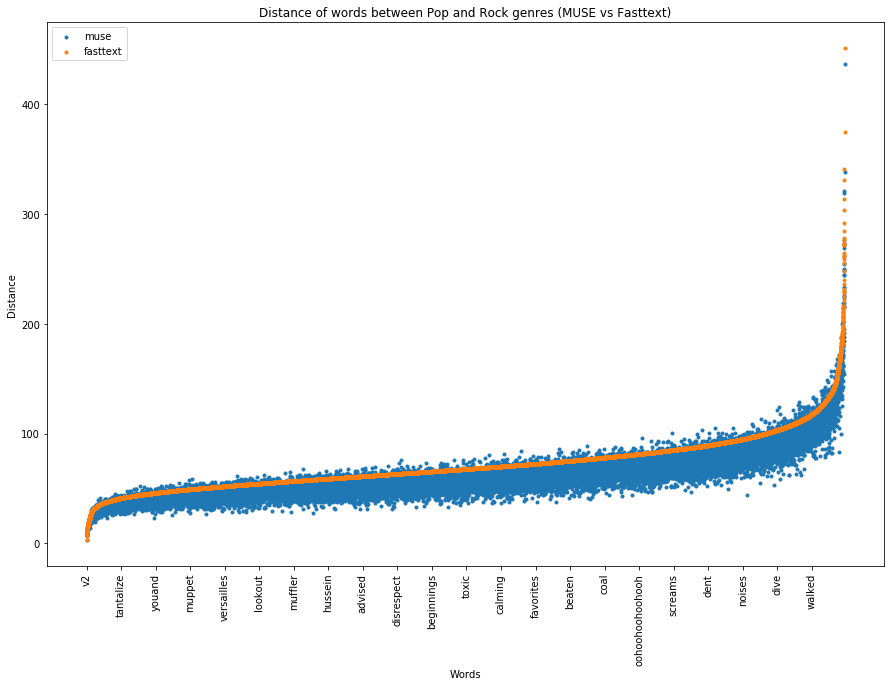

In [79]:
fig = plt.figure(figsize = (15, 10))

x = range(len(ordered_common_words))
plt.scatter(x, ordered_muse_dist, label = "muse", marker = '.')
plt.scatter(x, ordered_fasttext_dist, label = "fasttext", marker = '.')
plt.xticks(np.arange(min(x), max(x)+1, 1000),ordered_common_words[::1000], rotation='vertical')
plt.ylabel('Distance')
plt.xlabel('Words')
plt.title('Distance of words between Pop and Rock genres (MUSE vs Fasttext)')
plt.legend()
plt.show()

We see in the previous plot the difference in distances for each word. We expect the orange curve to be above the blue points, meaning that MUSE reduced the distance. We will now explore more the proportion of blue points above their corresponding orange point.

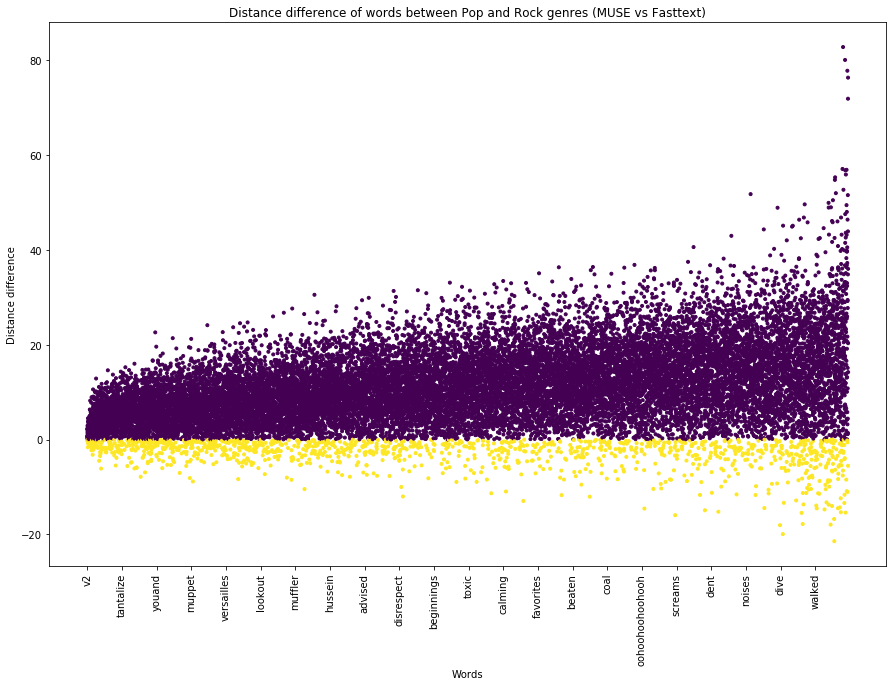

In [80]:
fig = plt.figure(figsize = (15, 10))
dist_diff = ordered_fasttext_dist - ordered_muse_dist
cmap = [ x < 0 for x in dist_diff]
x = range(len(ordered_common_words))

plt.scatter(x, dist_diff, label = "Difference", marker = '.', c = cmap)
plt.xticks(np.arange(min(x), max(x)+1, 1000),ordered_common_words[::1000], rotation='vertical')
#plt.hlines(0, 0 , len(ordered_common_words))
plt.title("Distance difference of words between Pop and Rock genres (MUSE vs Fasttext)")
plt.xlabel("Words")
plt.ylabel("Distance difference")
plt.show()

In this plot we see in more details whether MUSE reduced the distance (purple points) or increased the distance (yellow points). We can conclude that most of the points have a reduced distance, let's try to understand the repartition.

Gaussian ( 10.669759953859229 , 7.8497238536668545 )


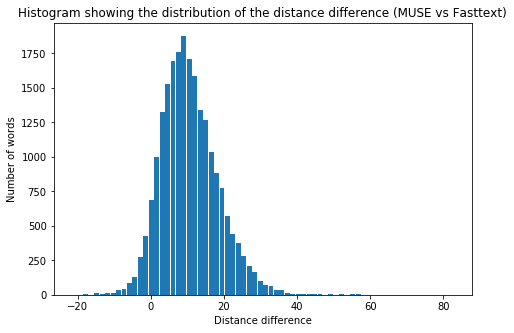

In [81]:
# best fit of data
(mu, sigma) = norm.fit(dist_diff)
print("Gaussian (",mu,",", sigma,")")
fig = plt.figure(figsize = (7.5, 5))
plt.hist(dist_diff, bins=70, rwidth = 0.9)
plt.title("Histogram showing the distribution of the distance difference (MUSE vs Fasttext)")
plt.xlabel("Distance difference")
plt.ylabel("Number of words")
plt.show()

We here fit a Gaussian to the distances to characterize clearly the distances. We see here that in average the distance is reduced by 10. As the dimension is 100, it means that MUSE reduces by approximately 0.1 every dimension. As the result of this project highly depends on this alignment, one could explore more deeply how to increase this number. We could try to reduce the dimension. Later in this notebook, we tried to reduce the number of common words as this would give MUSE more flexibility to align the vocabularies.

[Go to MUSE](#muse)

<a id="preds"></a>

### Predictions

In order to do the predictions we will follow the following steps:
- We will compute the Nearest Neighbors object from the <b>sklearn</b> library on the MUSE embeddings to quickly find the embeddings close to a given word in the target genre
- Compute the vocabulary specific to the input genre
- We will find the subset of words in the input lyrics that are the more specific to the genre
- We will look for the nearest neighbors of those words in the target language and replace them.

In [24]:
neigh_pop = NearestNeighbors(n_neighbors=3)
neigh_pop.fit(muse_emb_pop)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [25]:
#Function giving the embeddings the closest to the one given in parameters.
#According to our number of neighbors given in the cell above the format is: 1 embedding -> 3 embeddings
def get_nearest_embed(emb):
    idx = neigh_pop.kneighbors([emb],return_distance=False)
    return muse_emb_pop[idx][0]

In [26]:
#Function returning the desired nearest neighbor of the given word
#Format : word, neighbor desired -> neighbor chosen, all 3 neighbors (for completeness)
def get_swap_word(w, nb_neighbor):
    emb = muse_voc2embed_rock[w]
    nearest_pop_emb = get_nearest_embed(emb)
    words = []
    for i in range(3):
        words.append(muse_embed2voc_pop[tuple(list(nearest_pop_emb[i]))])
    return words[nb_neighbor], words

In [27]:
#Helper class to help the formatting of new lyrics
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


In [63]:
#Select a random song
rand_idx = random.randint(1,len(corpus_rock))
input_lyrics = corpus_rock[rand_idx]
input_lyrics

'we lost the paradise of curiousity now we re bound to live in anxiety all we have is hope to find the answer of the greatest question will we live forever we all dream of so we head on now cast aside your fears and start believing in there s a world beyond this a beginning we may not see it now but in the final it will be much greater than our survival we all dream of so we head on in a new tomorrow with all the reasons we can watch our past and all the seasons now we know the answer and if you wonder we can tell you we will live forever we all dream of so we head on'

In most cases, the lyrics don't have words that are specific to its genre (as we saw that the percentage was low, this is no surprise). To complete the list of words to swap, we get the words with the highest TF-IDF score. <br>
However when swapping a word from the TF-IDF list, we decided to take the second nearest neighbor as the first one could be the exact same word (as the word is present in both vocabularies, it would in fact be a sign that MUSE aligned particularly well the vocabularies). 

In [64]:
#Gather the list of words specific to the rock genre (meaning they are absent from the pop vocabulary)
words_spec_rock = []
for w in input_lyrics.split(' '):
    if w in rock_specific:
        words_spec_rock.append(w)
#print(words_spec_rock)

#Make a list with all the words from the lyrics and a list with their indices in the TF_IDF ordering.
#If 'guitar' is in the lyrics and appears third in the TF-IDF list, we have 'guitar' and 3
words_in_tfidf = []
idx_of_tfidf = []
for w in input_lyrics.split(' '):
    idx = np.where(tfidf_rock==w)[0]
    if len(idx)!= 0:
        words_in_tfidf.append(w)
        idx_of_tfidf.append(idx[0])

#We can now order our list of words according to their order of appearance in the TF-IDF list:
#ie : idx_of_tfidf = [3,2,5] --> np.argsort(idx_of_tfidf) = [1,0,2]
#This would transform the list ['guitar','bad','roll'] into ['bad', 'guitar', 'roll']
ordered_terms = np.array(words_in_tfidf)[np.argsort(idx_of_tfidf)]
#Here the terms are ordered by appearance in the tf-idf scores. However we need the highest scores first, so reverse
ordered_terms = ordered_terms[::-1]
#print(ordered_terms)

#We get the swap word for every rock specific word
SWAP_ROCK = list(set(words_spec_rock))
swap = {}
for w in SWAP_ROCK:
    try:
        new_word, neighbor_words = get_swap_word(w, 0)
        print(w, '--> ', neighbor_words)
        swap[w] = new_word
    except:
        print(w," is not in the pop vocabulary")
#Print a characterised string to note the end of the Rock specific words and change to TF-IDF identified words
print('-----')
#Now we must complete our swap dictionary with the words from the TF-IDF computations 
#until we meet our specified number of words to swap (ie 10)
i = 0
while len(swap.keys()) < 10 and i < len(ordered_terms):
    w = ordered_terms[i]
    if w not in swap.keys():
        try:
            new_word, neighbor_words = get_swap_word(w, 1)
            #Print all the neighbors identified
            print(w, '--> ', neighbor_words)
            #Include in the dictionary the selected neighbor
            swap[w] = new_word
        except : 
            print("error for ", w)
    i += 1

-----
dream -->  ['dishonest', 'honest', 'imaginary']
beginning -->  ['persistent', 'persuasive', 'understandable']
lost -->  ['malone', 'meantime', 'eventually']
tell -->  ['knowow', 'knowowow', 'babyyy']
answer -->  ['misunderstand', 'provocative', 'understand']
head -->  ['annoyed', 'honored', 'scanned']
question -->  ['composure', 'selfconfidence', 'compatible']
world -->  ['insincerity', 'misconception', 'inception']
know -->  ['wantyou', 'wantdon', 'wanya']
forever -->  ['adhere', 'hesitant', 'reprieve']


In [65]:
#Print new lyrics, with new words in bold for readability
words = input_lyrics.split(' ')
for i, w in enumerate(words):
    if w in swap.keys():
        words[i] = color.BOLD + swap[w] + color.END

print(' '.join(words))

we meantime the paradise of curiousity now we re bound to live in anxiety all we have is hope to find the provocative of the greatest selfconfidence will we live hesitant we all honest of so we honored on now cast aside your fears and start believing in there s a misconception beyond this a persuasive we may not see it now but in the final it will be much greater than our survival we all honest of so we honored on in a new tomorrow with all the reasons we can watch our past and all the seasons now we wantdon the provocative and if you wonder we can knowowow you we will live hesitant we all honest of so we honored on


Here we can see that the embeddings are not enough. Indeed the part of speech is not always respected (ie, 'lost' a verb is replaced by 'meantime', a noun or even 'dream' a noun replaced by 'honest' an adjective). In some other cases as 'tell' being replaced by 'knowowow' (or 'know' if cleaned) the replacement is nice as the meaning is preserved. There are some lucky repaclement as with 'forever' and 'hesitant'. We finally note the word 'head' having all past tense verbs as neighbors, which is wrong but we can understand the similitude.

[Go to MUSE](#muse)

<a id="pmuse"></a>

### Partial MUSE
In this part we will explain the work we did to analyse the impact of the common words for the training of the MUSE step. <br>
Before we had 100% of the words shared by the rock and pop vocabulary. Now we will work with 75%, 50% and 25% of those common words. The idea is that having less words to match perfectly, gives MUSE more flexibility and room to compute the matching. We will here compare the different predictions made.

In [81]:
#This first method will create the vocabularies with decrease proportion of common words.
# perc is the percentage of common words to keep
def get_partial_vocabularies(perc):
    #We compute the number of words to remove, so 1-perc
    nb_to_remove = int(np.round((1-perc)*len(common_words)))
    print("Number of common words removed : ", nb_to_remove)
    #We randomly select the words, within the common_words, to remove
    selected_common_words = random.sample(common_words, nb_to_remove)
    #We create copies of the vocabulary
    selected_pop_voc = list(copy.deepcopy(vocabulary_pop))
    selected_rock_voc = list(copy.deepcopy(vocabulary_rock))
    selected_pop_embed = list(copy.deepcopy(word_embeddings_pop))
    selected_rock_embed = list(copy.deepcopy(word_embeddings_rock))
    #We put as NaN the values we want to delete
    for w in selected_common_words:
        idx_pop = vocabulary_pop.index(w)
        idx_rock = vocabulary_rock.index(w)
        selected_pop_voc[idx_pop] = 'NaN'
        selected_pop_embed[idx_pop] = 'NaN'
        selected_rock_voc[idx_rock] = 'NaN'
        selected_rock_embed[idx_rock] = 'NaN'
    #And we filter out the NaN values
    selected_pop_voc = list(filter(lambda x: x != 'NaN', selected_pop_voc))
    selected_pop_embed = list(filter(lambda x: x != 'NaN', selected_pop_embed))
    selected_rock_voc = list(filter(lambda x: x != 'NaN', selected_rock_voc))
    selected_rock_embed = list(filter(lambda x: x != 'NaN', selected_rock_embed))
    
    return selected_pop_voc, selected_pop_embed, selected_rock_voc, selected_rock_embed

In [82]:
pop_voc_75, pop_embed_75, rock_voc_75, rock_embed_75 = get_partial_vocabularies(0.75)

Number of common words removed :  5488


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [83]:
pop_voc_50, pop_embed_50, rock_voc_50, rock_embed_50 = get_partial_vocabularies(0.5)

Number of common words removed :  10975


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [84]:
pop_voc_25, pop_embed_25, rock_voc_25, rock_embed_25 = get_partial_vocabularies(0.25)

Number of common words removed :  16462


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Once we got those partial vocabularies, we need to create the '.vec' files, matching the output format from the FastText library so that we can use those files in the MUSE procedure.

In [198]:
def create_vec_file(file_name, voc, embed):
    with codecs.open(file_name, 'w', 'utf-8') as f:
        #First line must have number of words and dimension
        f.write(str(len(voc))+' 100\n')
        # We need to transform our numpy array into a string of the word followed by numbers separated with a space
        for i,w in enumerate(voc):
            l = w + ' '
            for x in embed[i]:
                l = l + str(round(x,7)) + ' '
            l = l + '\n'
            f.write(l)

In [254]:
create_vec_file('data/MUSE/model_lyrics_pop_75.vec', pop_voc_75, pop_embed_75)
create_vec_file('data/MUSE/model_lyrics_pop_50.vec', pop_voc_50, pop_embed_50)
create_vec_file('data/MUSE/model_lyrics_pop_25.vec', pop_voc_25, pop_embed_25)
create_vec_file('data/MUSE/model_lyrics_rock_75.vec', rock_voc_75, rock_embed_75)
create_vec_file('data/MUSE/model_lyrics_rock_50.vec', rock_voc_50, rock_embed_50)
create_vec_file('data/MUSE/model_lyrics_rock_25.vec', rock_voc_25, rock_embed_25)

For this set-up we made the following change: the target genre will be the partial file and the source genre remains the same file.

In [66]:
N_EPOCH = 50
BATCH_SIZE = 32
N_ITERATION = round(len(voc_rock)/BATCH_SIZE)
REFINEMENT = 50 #Refinement is for the Procrustes Iterations, involved in the rotation of the embeddings
INPUT_GENRE = "rock"
OUTPUT_GENRE = "pop"
MODEL_ROCK = 'data/MUSE/model_lyrics_'+ INPUT_GENRE +'.vec'
CHOSEN_PERC = str(75)
MODEL_POP = 'data/MUSE/model_lyrics_'+ OUTPUT_GENRE+'_'+CHOSEN_PERC+'.vec'
SRC_LANG = 'MUSE_'+ INPUT_GENRE +'_'+ CHOSEN_PERC
TGT_LANG = 'MUSE_'+ OUTPUT_GENRE+'_'+ CHOSEN_PERC

In [115]:
data = ! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT
analyse_run(data)

For dump  wnckibdcl1  the best mean cosine was  0.61150  reached at  refinement iteration 49


In [67]:
muse_emb_rock, muse_voc_rock = load_embeddings('data/MUSE/vectors-MUSE_'+ INPUT_GENRE +'_'+ CHOSEN_PERC+ ".txt")
muse_emb_pop, muse_voc_pop = load_embeddings('data/MUSE/vectors-MUSE_'+ OUTPUT_GENRE +'_'+ CHOSEN_PERC+ ".txt")

In [68]:
emb_pop, voc_pop = load_embeddings('data/MUSE/model_lyrics_pop_'+ CHOSEN_PERC+ '.vec')
emb_rock, voc_rock = load_embeddings('data/MUSE/model_lyrics_rock_'+ CHOSEN_PERC+ '.vec')

In [69]:
voc2embed_rock, embed2voc_rock = get_dict(emb_rock, voc_rock)
voc2embed_pop, embed2voc_pop = get_dict(emb_pop, voc_pop)

In [70]:
muse_voc2embed_rock, muse_embed2voc_rock = get_dict(muse_emb_rock, muse_voc_rock) 
muse_voc2embed_pop, muse_embed2voc_pop = get_dict(muse_emb_pop, muse_voc_pop) 

[Go to MUSE](#muse)

<a id="comparison"></a>

### Comparison of predictions

In [89]:
#Pick one song at random in the rock corpus
rand_idx = random.randint(1,len(corpus_rock))
input_lyrics = corpus_rock[rand_idx]
input_lyrics

'and we say back way to all the trouble makers better fix up your brains because you are the biggest fakers come in the place better know who you are self defense is no offense the scales of justice are weighed down on one side freemasons on the case you know you re gonna get a rough ride hold tight even if you know your rights it s just a piece of paper unless you re prepared to fight for ten years one hell of a long time to rot in a cell when you ve committed no crime another innocent man forced to carry the can free satpal ram free satpal ram another innocent man whose word against who whose word against who the degenerate crew out on the town thought they had something to prove self defense only offense had to protect himself from all the murdering fools cutting remarks on account of his race a plate to his chest and a glass to his face an asian fights back can t afford to be meek with your back against the wall you can t turn the other cheek and its back way to all the trouble mak

In [90]:
#Apply our 2 step selection of words to swap
words_spec_rock = []
for w in input_lyrics.split(' '):
    if w in rock_specific:
        words_spec_rock.append(w)

words_in_tfidf = []
idx_of_tfidf = []
for w in input_lyrics.split(' '):
    idx = np.where(tfidf_rock==w)[0]
    if len(idx)!= 0:
        words_in_tfidf.append(w)
        idx_of_tfidf.append(idx[0])

ordered_terms = np.array(words_in_tfidf)[np.argsort(idx_of_tfidf)]
ordered_terms = ordered_terms[::-1]

SWAP_ROCK = list(set(words_spec_rock))

In [73]:
#Load given dataset, process and return swap_dict
def process(muse_pop, muse_rock):
    muse_emb_rock, muse_voc_rock = load_embeddings(muse_rock)
    muse_emb_pop, muse_voc_pop = load_embeddings(muse_pop)
    muse_voc2embed_rock, muse_embed2voc_rock = get_dict(muse_emb_rock, muse_voc_rock) 
    muse_voc2embed_pop, muse_embed2voc_pop = get_dict(muse_emb_pop, muse_voc_pop) 
    neigh_pop = NearestNeighbors(n_neighbors=3)
    neigh_pop.fit(muse_emb_pop)
    
    #Redefine the 2 following functions so that they use the correct neigh_pop, muse_emb_pop, etc.
    def get_nearest_embed(emb, genre):
        if genre == 'pop':
            idx = neigh_pop.kneighbors([emb],return_distance=False)
            return muse_emb_pop[idx][0]
    
    def get_swap_word(w, nb_neighbor, genre):
        emb = muse_voc2embed_rock[w]
        nearest_pop_emb = get_nearest_embed(emb, genre)
        words = []
        for i in range(3):
            words.append(muse_embed2voc_pop[tuple(list(nearest_pop_emb[i]))])
        return words[nb_neighbor], words
    
    swap = {}
    for w in SWAP_ROCK:
        new_word, neighbor_words = get_swap_word(w, 0, 'pop')
        swap[w] = new_word

    i = 0
    while len(swap.keys()) < 10 and i < len(ordered_terms):
        w = ordered_terms[i]
        if w not in swap.keys():
            try:
                new_word, neighbor_words = get_swap_word(w, 1, 'pop')
                swap[w] = new_word
            except : 
                print("error for ", w)
        i += 1
    return swap

In [74]:
#Safety function in case some swap words would be missing form the dictionary
def get_word(w, swap_dict):
    try:
        return swap_dict[w]
    except:
        return 'X'

In [91]:
#Get the swap dictionaries for all 4 cases
swap_100 = process('data/MUSE/vectors-MUSE_pop.txt', 'data/MUSE/vectors-MUSE_rock.txt')
swap_75 = process('data/MUSE/vectors-MUSE_pop_75.txt', 'data/MUSE/vectors-MUSE_rock_75.txt')
swap_50 = process('data/MUSE/vectors-MUSE_pop_50.txt', 'data/MUSE/vectors-MUSE_rock_50.txt')
swap_25 = process('data/MUSE/vectors-MUSE_pop_25.txt', 'data/MUSE/vectors-MUSE_rock_25.txt')

#Compile the 4 dicts into a dataframe
swap_df = pd.DataFrame(columns = ['word', '100%', '75%', '50%', '25%'])
words = set(swap_100.keys()).union(set(swap_75.keys())).union(set(swap_50.keys())).union(set(swap_25.keys()))
for w in words:
    swap_df.loc[len(swap_df)] = [w, get_word(w, swap_100), get_word(w, swap_75),get_word(w, swap_50), get_word(w, swap_25)]
    
swap_df

,word,100%,75%,50%,25%
0,racists,embalming,erupts,dvds,dvds
1,say,saysay,ccause,anyday,heyday
2,hold,entrust,troublemaker,possibly,knave
3,time,infront,unintentionally,timeslide,precisely
4,ride,weeny,buzzed,controllin,pendergrass
5,fight,obsessive,convincin,reassured,connive
6,carry,retrieve,exhibit,adhere,finder
7,trouble,excessive,befriended,misbehave,troublemaker
8,satpal,epitome,schizophrenic,ymcmb,schizophrenic
9,prosecution,compulsion,repercussions,advertised,premonition


We can see here how the prediction gets worse with the decreasing percentage of common words. By worse we mean that either the meaning gets lost or the part of speech (making the sentence grammatically wrong). Examples are here:
- fight -> obssessive -> convincin can be good predictions, reassured or connive are changing the meaning but could still fit
- carry -> retrieve -> exhibit -> adhere are all words, their meaning is gradually drifting from the first one but the last word 'finder' has nothing to do with the context.
- trouble -> excessive -> befriended could be used in a sentence but clearly if 'misbehave' and 'troublemaker' have a similar meaning, they cannot be placed in the same sentence

In conclusion, we will keep working with 100% of the common words.

## Prediction Pipeline

We will here make a summary of the different steps to follow if you would like to transfer the specific words of a song from a genre 1 to specific words of a genre 2 using our MUSE approach. <br>
Below, we will call genre 1 '<i>source genre</i>' and genre 2 '<i>target genre</i>'. The necessary steps are:
- Identify the specific vocabulary of the source genre (meaning words in the source genre not used in the target genre): this will be used to spot the most relevant words to swap
- Compute the TF-IDF ordering of the source vocabulary: this will be used to complete the list of interesting words for the transfer
- Obtain the MUSE embeddings of the target genre: this is the space where we look for similar vectors to make the prediction
- Create the Nearest Neighbors object of the target genre: this requires the MUSE embeddings and is the tool to make the prediction
- Get the dictionary MUSE vocabulary -> embedding of the source genre: this is used to encode the identified words into our search space (embeddings)
- Get the dictionary MUSE embedding -> vocabulary of the target genre: this is used, once we got the result from the Nearest Neighbors search, to decode the embedding into the correct word

The most tricky part is to get the MUSE embeddings. To get this, you will need the FastText embeddings of both genres, which can be obtained with text files containing the corpus of each genre. If the FastText library let us choose only between skipgram and cbow algorithms, the MUSE library provides more parameters to play with: the number of epochs, the batch size, the number of refinement iterations, the validation metric etc. Unfortunately the code provided by the Facebook Research Team is not very well documented and revealed itself to be tricky to understand.

In order to run our demo, with user-friendly delays, please run the following cell (so that all the necessary files are saved):

In [ ]:
pickle.dump(rock_specific ,open("data/demo/rock/specific_from_pop.py", "wb" )) #Source genre
pickle.dump(tfidf_rock,open("data/demo/rock/tfidf.py", "wb")) #Source genre
pickle.dump(muse_emb_pop, open("data/demo/pop/muse_emb_with_rock.py", "wb")) #target genre
pickle.dump(muse_voc2embed_rock,open("data/demo/rock/muse_voc2embed_with_pop.py", "wb")) #source genre
pickle.dump(muse_embed2voc_pop,open("data/demo/pop/muse_embed2voc_with_rock.py", "wb")) #target genre

If you'd like to use our demo with another pair of genres, we recommend that you follow the execution of the dedicated notebook <u>MUSE file creation</u>, available with this one.

[Go to top](#top)

<a id="nn"></a>

## Neural Network

- [Input pre-processing](#prepro)
- [Exclusive words](#exword)
- [Part of speech](#pos)
- [Most common words](#commonwords)
- [Sample words](#samplewords)
- [Words Tokenization](#tokens)
- [Input of Neural Net](#inputnn)
- [Model Creation](#createnn)
- [Predict words](#predict)
- [Lyrics Generation](#lyricsgen)
- [Genre Fusion](#fusion)

In this part, we will explore another strategy and build a neural network. Its goal will be to do some word predictions on the lyrics and transform them from one genre to another. <br>
First we will visualize the amount of lyrics that we have for the distinct genres:

In [96]:
lyrics_df = pd.read_csv('data/lyrics_final_clean.csv')
MAIN_GENRES = {'pop', 'rock', 'metal', 'country', 'jazz', 'hip hop'}

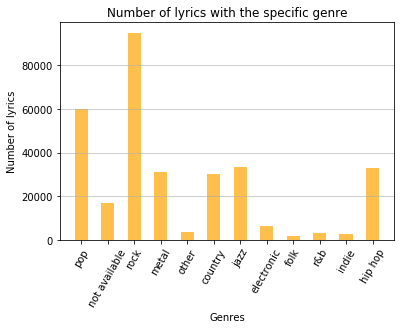

In [97]:
n, bins, patches = plt.hist(x = list(lyrics_df["genre"]), bins=np.arange(0,len(set(lyrics_df["genre"])) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of lyrics')
plt.title('Number of lyrics with the specific genre')
plt.xticks(rotation=60)
plt.show()

We will only focus on genres with sufficient number of lyrics: rock, pop, metal, jazz, country, hip hop. For each of these genres we have more than 30'000 lyrics in our dataset

[Go back to Neural Net](#nn)

<a id="prepro"></a>

## Input pre-processing

Import the dictionnaries of word embeddings computed previously with fasttext:

In [98]:
# Load embeddings
file_vec = 'data/fasttext_preprocessing/model_lyrics_skipgram.vec'
file_bin = 'data/fasttext_preprocessing/model_lyrics_skipgram.bin' # Not useful and file too big for Github
fasttext_exe = 'data/fasttext_preprocessing/fasttext'

def load_embeddings(file_name):
    """
    Load the embeddings from the .vec file given as input
    """
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

# This method is typically called for words with no embeddings in the dictionary
def get_embedding_for_missing_word(w):
    """
    Given a word as input, computes it's fasttext vector using the file_bin file
    """
    data = ! echo $w | $fasttext_exe print-word-vectors $file_bin
    emb = np.zeros(100)
    for i, x in enumerate(data[0].split( )[1:]):
        try:
            emb[i] = float(x)
        except ValueError:
            print(data[0])
    return emb

word_embeddings, vocabulary = load_embeddings(file_vec)

In [99]:
# Create dictionaries
voc_embeds_dict = {}
embeds_voc_dict = {}

for voc, embed in zip(vocabulary, word_embeddings):
    voc_embeds_dict[voc] = tuple(embed)
    embeds_voc_dict[tuple(embed)] = voc
    
print(len(voc_embeds_dict))

85899


Search for all the words in the lyrics that are not in the embeddings.

In [ ]:
# THIS CELL TAKES LONG TIME TO RUN: NO NEED TO RUN IF YOU HAVE THE missing_words.csv file
def find_missing_words(lyrics, vocab):
    """
    Given lyrics of songs, find the words in it that are not in the vocabulary (word embeddings)
    """
    sentences = str(lyrics).replace('\n', ' ')
    list_words = sentences.split(' ')
    missing_words = set(list_words).difference(vocab)
    return missing_words


vocab = set(voc_embeds_dict.keys())
missing_vocab = set()

for i, row in lyrics_df.iterrows():
    if i % 1000 == 999:
        print(float(i)/ len(lyrics_df))
    lyrics = row['lyrics']
    missing_words = find_missing_words(lyrics, vocab)
    
    missing_vocab = missing_vocab.union(missing_words)
    vocab = vocab.union(missing_words)

In [425]:
# Remove duplicates
missing_vocab_lst = list(set(missing_vocab_lst))
print(len(missing_vocab_lst))
print(missing_vocab_lst[:50])

229149
['', 'keopeulling', 'faithmy', 'abraim', 'lutenant', 'drup', 'pinehill', 'dubar', 'proovalizing', 'mour', 'amortization', 'macmahon', 'wohohohoh', 'dribs', '146', 'vechouski', 'stevies', 'speciments', 'dauphine', 'machangajingeol', 'eastends', 'misquete', 'leatherfeathered', 'ayyet', 'melodytrouble', 'lamarque', 'fashionkilla', 'heemed', 'ghuana', 'yanamean', 'clannad', 'strategized', 'blaoww', 'chicagoo', 'arthgolano', 'brk', 'trickier', 'macgregors', 'mimimimind', 'giddedygot', 'asseth', 'willliehaeyyy', 'polako', 'mahuckin', 'telltales', 'dahomey', 'honeypie', 'virany', 'twentymillion', 'berlington']


In [100]:
missing_words_file = 'data/fasttext_preprocessing/missing_words.csv'
# Save missing words
"""with open(missing_words_file, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in missing_vocab_lst:
        writer.writerow([val])"""
        
# Read missing words
with open(missing_words_file, 'r') as f:
    reader = csv.reader(f)
    missing_vocab_lst = [ls_word[0] for ls_word in list(reader)]
print("{} distinct missing words".format(len(missing_vocab_lst)))

229149 distinct missing words


The idea was to fetch the embeddings of all these missing words using the get_embedding_for_missing_word function. However, this took way too long to compute for all the missing words.

Most of the missing words are actual words with spelling mistakes: lots of them contain a same letter repeating multiple times (e.g. Wwwwwworld instead of world). Thus we use <b>regex</b> to map these words to their actual correct representation:

In [101]:
vocab = set(voc_embeds_dict.keys())
bad_good_word_dict = {}
for i, w in enumerate(missing_vocab_lst):
    correct_w = re.sub(r'(.)\1{2,}', r'\1', w)
    if correct_w in vocab:
        bad_good_word_dict[w] = correct_w
print("Number of correct mapped words: {}".format(len(bad_good_word_dict)))

Number of correct mapped words: 5568


Now let's transform the lyrics as follows. For each word:
- If the word is in the voc_embeds_dict dictionary, keep the word (it has an embedding)
- Else if the word is in the bad_good_word_dict, fetch the corresponding good word (missing word with a matching)
- Else remove the word from the lyrics (we don't have its embedding and it's too long to compute it for each word)

Transform lyrics by keeping only the words that have fasttext embeddings

In [102]:
def lyrics_to_list_words(lyrics, vocab):
    """
    Given lyrics, keep only the words with the embeddings
    """
    sentences = str(lyrics).replace('\n', ' ') # Don't consider end of words
    list_words = sentences.split(' ')
    list_words_cleaned = []
    incorrect_count = 0
    
    for w in list_words:
        if w in voc_embeds_dict.keys():
            list_words_cleaned.append(w)
        elif w in bad_good_word_dict.keys():
            # Get matching word
            correct_w = bad_good_word_dict[w]
            list_words_cleaned.append(correct_w)
        else: 
            # Word with no embedding, don't consider it
            incorrect_count += 1 
    return list_words_cleaned, incorrect_count

In [103]:
def get_list_words_from_df(df, vocab):
    """
    Given a dataframe, apply the lyrics_to_list_words on each lyrics of the dataframe
    """
    lyrics_cleaned = []
    total_incorrect = 0

    for i, row in df.iterrows():    
        lyrics = row['lyrics']
        words_cleaned, c = lyrics_to_list_words(str(lyrics), vocab)
        total_incorrect += c
        lyrics_cleaned.append(words_cleaned)
    print("Average number of incorrect words per song: {}".format(float(total_incorrect) / len(df)))
    return lyrics_cleaned

def list_lyrics_genre(entire_df, entire_vocab, genre):
    """
    Get the list of lyrics with "non-missing" words (list of words) for a given genre
    """
    df_genre = entire_df[entire_df['genre'] == genre]
    print("Number lyrics for genre {} : {}".format(genre, len(df_genre)))
    list_lyrs_genre = get_list_words_from_df(df_genre, entire_vocab)
    return list_lyrs_genre

In [104]:
vocab = set(voc_embeds_dict.keys())
list_lyrics = get_list_words_from_df(lyrics_df, vocab)

Average number of incorrect words per song: 8.113108212545148


In [105]:
list_lyrs_pop = list_lyrics_genre(lyrics_df, vocab, 'pop')
list_lyrs_rock = list_lyrics_genre(lyrics_df, vocab, 'rock')
list_lyrs_metal = list_lyrics_genre(lyrics_df, vocab, 'metal')
list_lyrs_jazz = list_lyrics_genre(lyrics_df, vocab, 'jazz')
list_lyrs_hiphop = list_lyrics_genre(lyrics_df, vocab, 'hip hop')
list_lyrs_country = list_lyrics_genre(lyrics_df, vocab, 'country')

Number lyrics for genre pop : 59850
Average number of incorrect words per song: 9.592147034252298
Number lyrics for genre rock : 94938
Average number of incorrect words per song: 3.3855147569993047
Number lyrics for genre metal : 31320
Average number of incorrect words per song: 6.085983397190294
Number lyrics for genre jazz : 33536
Average number of incorrect words per song: 9.372286498091603
Number lyrics for genre hip hop : 33024
Average number of incorrect words per song: 23.560804263565892
Number lyrics for genre country : 30247
Average number of incorrect words per song: 7.217244685423347


Depending on the genre, we have more or less words with missing embedding but this number isn't huge except for hip hop lyrics (23.5 missing words per song in average). We figured out that it is ok to remove these words from the lyrics.

Check lengths of lyrics repartitions and we keep only the lyrics with more than 30 words, otherwise lyrics might be outliers.

In [106]:
def get_lyrics_above(list_lyrics, min_nbr_words = 30):
    lengths_lyrics = [len(l) for l in list_lyrics]
    print("Words per lyrics: Min: {}, Max: {}, Avg: {}".format(min(lengths_lyrics), max(lengths_lyrics), np.mean(lengths_lyrics)))

    # Keep lyrics with more than certain number of words
    list_lyrics_nomin = [l for l in list_lyrics if len(l) > min_nbr_words]
    lengths_lyrics = [len(l) for l in list_lyrics_nomin]
    print("Ratio lyrics kept: {}".format(len(list_lyrics_nomin) / len(list_lyrics)))
    return list_lyrics_nomin, lengths_lyrics

In [107]:
list_lyrs_pop, lengths_pop = get_lyrics_above(list_lyrs_pop)
list_lyrs_rock, lengths_rock = get_lyrics_above(list_lyrs_rock)
list_lyrs_metal, lengths_metal = get_lyrics_above(list_lyrs_metal)
list_lyrs_jazz, lengths_jazz = get_lyrics_above(list_lyrs_jazz)
list_lyrs_hiphop, lengths_hiphop = get_lyrics_above(list_lyrs_hiphop)
list_lyrs_country, lengths_country = get_lyrics_above(list_lyrs_country)

Words per lyrics: Min: 0, Max: 3365, Avg: 247.924544695071
Ratio lyrics kept: 0.9945196324143692
Words per lyrics: Min: 0, Max: 6300, Avg: 202.37651941266932
Ratio lyrics kept: 0.9892982788767406
Words per lyrics: Min: 0, Max: 2377, Avg: 188.33288633461046
Ratio lyrics kept: 0.9791507024265645
Words per lyrics: Min: 0, Max: 2380, Avg: 183.74349952290078
Ratio lyrics kept: 0.9926645992366412
Words per lyrics: Min: 1, Max: 8179, Avg: 503.35425750968994
Ratio lyrics kept: 0.9904009205426356
Words per lyrics: Min: 0, Max: 2736, Avg: 199.3980890666843
Ratio lyrics kept: 0.9972889873375872


[Go back to Neural Net](#nn)

<a id="exword"></a>

### Exclusive words for each genre

For this part we decided, for each genre, to compute the words appearing exclusively in this genre and not in the other ones. We also ensured that these found words are real words by comparing them with a dictionary of the english language (list words from <b>nltk</b> library).

The idea behind this is: <br> 
As the vocabulary size is huge, we would like to sample some words for each genre such that these words would be the most likely ones predicted by our neural network. In order to predict good words for a specific genre, we thought about considering the "exclusive" words as possible outputs for our neural network for the specific genre (and add other words). However, we noticed that these exclusive words might not appear often and this would reduce the entire size of the training set for our neural net. Moreover, we noticed that these unique words are "weird" words because they don't appear at all in all the other lyrics of the other genres. We decided not to use these words and found a better and smarter alternative that will be explained below.    

In [17]:
def unique_words(list_lyrs):
    """
    Given list of lyrics (list of words), return the set of all words
    """
    all_words = []
    for l in list_lyrs:
        for w in l:
            all_words.append(w)
    unique_words = set(all_words)
    print("Number of unique words: {}".format(len(unique_words)))
    return unique_words 

In [18]:
# Distinct words
words_pop = unique_words(list_lyrs_pop)
words_rock = unique_words(list_lyrs_rock)
words_metal = unique_words(list_lyrs_metal)
words_jazz = unique_words(list_lyrs_jazz)
words_hiphop = unique_words(list_lyrs_hiphop)
words_country = unique_words(list_lyrs_country)

# Common words in all genres
common_words = words_metal.intersection(words_rock).intersection(words_pop).intersection(words_jazz).intersection(words_hiphop).intersection(words_country)
print("Number of words common to all genres:", len(common_words))

Number of unique words: 57083
Number of unique words: 59368
Number of unique words: 44487
Number of unique words: 41731
Number of unique words: 61796
Number of unique words: 35441
20373


In [19]:
exclusive_metal = words_metal.difference(words_rock.union(words_pop).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_pop = words_pop.difference(words_rock.union(words_metal).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_rock = words_rock.difference(words_metal.union(words_pop).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_jazz = words_jazz.difference(words_rock.union(words_pop).union(words_metal).union(words_hiphop).union(words_country))
exclusive_hiphop = words_hiphop.difference(words_rock.union(words_pop).union(words_jazz).union(words_metal).union(words_country))
exclusive_country = words_country.difference(words_rock.union(words_pop).union(words_jazz).union(words_hiphop).union(words_metal))

# Keep only real existing words given by the nltk library
exclusive_metal = set(words.words()).intersection(exclusive_metal)
exclusive_pop = set(words.words()).intersection(exclusive_pop)
exclusive_rock = set(words.words()).intersection(exclusive_rock)
exclusive_jazz = set(words.words()).intersection(exclusive_jazz)
exclusive_hiphop = set(words.words()).intersection(exclusive_hiphop)
exclusive_country = set(words.words()).intersection(exclusive_country)

[Go back to Neural Net](#nn)

<a id="pos"></a>

### Part Of Speech (POS) for each genre

We are also interested in generating the Part Of Speech of a word (e.g. the type of the word: noun, verb, adverb...) to do this we will use the <b>spacy</b> library that allows to give the Part of Speech for a given word in a sentence. 

In [80]:
# Spacy library to compute the Parts Of Speech(POS) in a sentence
en_nlp = spacy.load('en')

Possible POS from the library:

ADJ: adjective, ADP: adposition, ADV: adverb, AUX: auxiliary verb, CONJ: coordinating conjunction, DET: determiner, INTJ: interjection, NOUN: noun, NUM: numeral, PART: particle, PRON: pronoun, PROPN: proper noun, PUNCT: punctuation, SCONJ: subordinating conjunction, SYM: symbol, VERB: verb and X: other.

We will first compute the necessary files to predict the next possible POS following the POS of the current word. Doing this will be useful in order to generate lyrics of a given genre by giving the expected POS that we expect, based on the previous one, as an input to the neural network.

In [78]:
#Function returning the part of speech for the given lyrics. We remove the SPACE POS as we are not interested in them.
def generate_pos_for_lyrics(l):
    doc = en_nlp(l)
    pos = []
    for i in range(len(doc)):
        type_ = doc[i].pos_
        if type_ != 'SPACE':
            pos.append(type_)
    return pos

In [ ]:
# We compute all the POS for all the lyrics (time consuming)
pos = []
length = len(lyrics_df)
for i, r in lyrics_df.iterrows():
    if i % 25000 == 0:
        print("I'm at row ", i)
    l = r['lyrics'].replace('\n', ' ')
    pos.append(generate_pos_for_lyrics(l))
    
pickle.dump(pos,open( "data/NN_models/PoS-computed.p", "wb" ))

In [97]:
pos = pickle.load( open( "data/NN_models/PoS-computed.p", "rb" ))
#We wonder what are the different POS found in the lyrics
set_pos = set()
for i in range(len(pos)):
    temp_set = set(pos[i])
    set_pos = set_pos.union(temp_set)

print("There are : ", len(set_pos), " different part of speech")
print("Here is the list : ", set_pos)

There are :  15  different part of speech
Here is the list :  {'ADJ', 'PART', 'INTJ', 'ADP', 'NUM', 'VERB', 'ADV', 'X', 'DET', 'SYM', 'PRON', 'PUNCT', 'PROPN', 'NOUN', 'CCONJ'}


In [84]:
#Function to create an empty dictionary to count the POS
def initiate_pos_dict():
    dict_ = {}
    for pos in set_pos:
        dict_[pos] = 0
    return dict_

In [98]:
total_count = initiate_pos_dict()
#We compute the total number of all POS    
for i in range(len(pos)):
    for j in range(len(pos[i])):
        total_count[pos[i][j]] += 1

In [99]:
#We create a list of one POS-count dictionary for each POS, altogether with dictionaries to match the index and POS
pos2idx = {}
idx2pos = {}
pos_counts = []
for i, p in enumerate(set_pos):
    pos2idx[p] = i
    idx2pos[i] = p
    pos_counts.append(initiate_pos_dict())
    
assert(len(pos_counts) == len(set_pos))

In [100]:
#For each POS, we count the number of each POS appearing next to it
for i in range(len(pos)):
    for j in range(len(pos[i]) - 1):
        curr_pos = pos[i][j]
        next_pos = pos[i][j+1]
        pos_counts[pos2idx[curr_pos]][next_pos] += 1

In [101]:
#Function to divide all the values of a dictionnary by a given value
#Used to turn the counts into probabilities (as we have the total appearance of all POS)
def divide_dict_per_value(d, value):
    d_total = 0
    for k, v in d.items():
        d[k] = v/value
        d_total += d[k]
    #Visual check to know if the sum of all probabilities equal 1
    print(d_total, " close to 1 ?")
    return d
#Turn counts into probabilities
for i, d in enumerate(pos_counts):
    pos_counts[i] = divide_dict_per_value(d, total_count[idx2pos[i]])

0.9960409486557056  close to 1 ?
0.9965140098574794  close to 1 ?
0.9902972870220809  close to 1 ?
0.9988433771859856  close to 1 ?
0.9929752864959156  close to 1 ?
0.9974558027024913  close to 1 ?
0.9944212909673213  close to 1 ?
0.9949616786028396  close to 1 ?
0.9995003566347609  close to 1 ?
0.9981532779316711  close to 1 ?
0.9965484875790659  close to 1 ?
0.9944525325188166  close to 1 ?
0.9953715334814958  close to 1 ?
0.9912144476105684  close to 1 ?
0.999922440330315  close to 1 ?


In [102]:
#We need to adjust the sum to be equal to 1 so that our prediction function can use the numpy random choice function
for i in range(15):
    prob = pos_counts[i]
    to_fill = 1 - sum(prob.values())
    max_prob = max(prob, key=prob.get)
    #We choose to add the small delta missing to the highest probability
    prob[max_prob] += to_fill
    print(sum(prob.values()))

1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0000000000000002


In [103]:
#We get the prior probability of appearance of any POS
total_nb_pos = 0
for k,v in total_count.items():
    total_nb_pos += v
    
prob_pos = divide_dict_per_value(total_count, total_nb_pos)

0.9999999999999999  close to 1 ?


In [104]:
#Function to draw the graph with the probabilities of next POS
def visualize_prob_dict(d, t):
    k = d.keys()
    x = range(0, len(k))
    y = d.values()
    fig = plt.figure(figsize = (15, 3))
    plt.gca().yaxis.grid(True)
    plt.scatter(x, y)
    plt.ylim((0,1))
    plt.xticks(x, k)
    plt.title(t)
    plt.show()

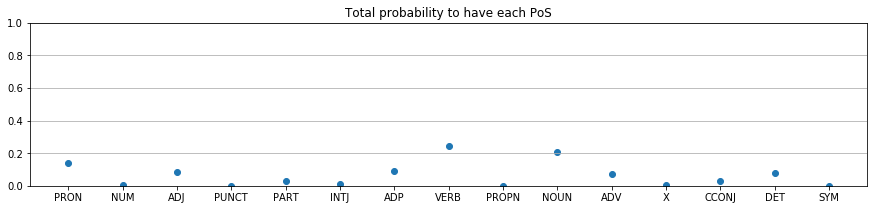

In [105]:
visualize_prob_dict(prob_pos, "Total probability to have each PoS")

We note that the more frequent POS are Verbs, Nouns, Pronouns, Adverbs, Determinants and Adjectives which make sense.

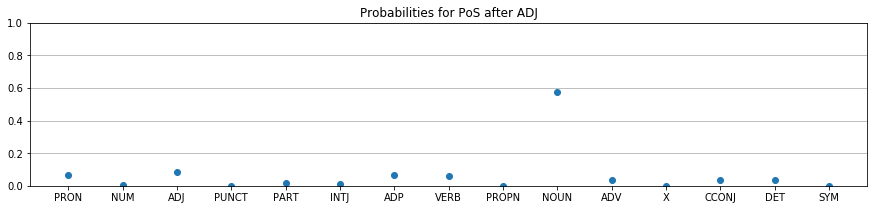

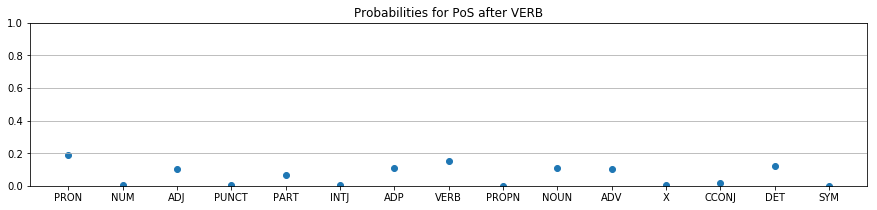

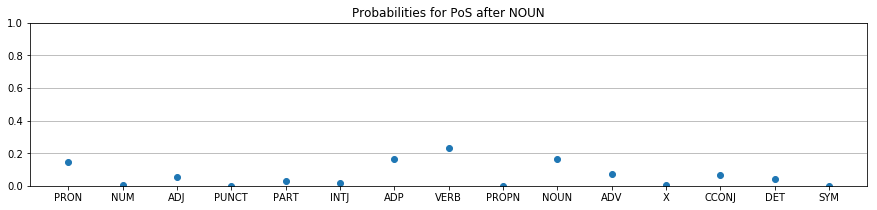

In [106]:
for pos in ['ADJ', 'VERB', 'NOUN']:
    d = pos_counts[pos2idx[pos]]
    t = "Probabilities for PoS after " + pos
    visualize_prob_dict(d, t)

We can see here that our prediction of part of speech makes sense : 
- We are really likely to predict a noun after an adjective
- After a verb we have multiple likely predictions
- Following a noun we often find a verb, another noun or an adposition (ie, "apple <b>on</b> the table")

In [ ]:
"""pickle.dump(pos_counts ,open( "data/NN_models/pos_counts.p", "wb" ))
pickle.dump(pos2idx, open( "data/NN_models/pos2idx.p", "wb" ))"""

Now that we know more about the Part of Speech from the base dataset, let's look at the distribution of part of speechs that we need to match in our set of possible predictions in our neural network.

For each genre we go through the lyrics of this genre and compute the POS distribution of the genre, the count of apparitions of each words, the POS of each words. For the POS of each word, sometimes a word can have multiple POS: (e.g. 'increase' can either be a NOUN or VERB), so we consider the final POS that appears the most for each word.

In [21]:
def generate_pos_for_lyrics(lyrs):
    """
    Compute the Part Of Speech (POS) of each word for given lyrics and return the list of POS and counter 
    for these lyrics"""
    doc = en_nlp(lyrs)
    word_pos_dict = {}
    list_pos = []
    
    for i in range(len(doc)):
        type_ = doc[i].pos_
        if type_ != 'SPACE' and type_ != 'PART' and type_ != 'X': # We don't want to keep these POS
            list_pos.append(type_)
            if str(doc[i]) not in word_pos_dict.keys():
                word_pos_dict[str(doc[i])] = {type_: 1}
            elif type_ not in word_pos_dict[str(doc[i])].keys():
                word_pos_dict[str(doc[i])][type_] = 1
            else:
                word_pos_dict[str(doc[i])][type_] += 1
    # list_pos: the list of POS appearing in the lyrics
    # Counter(list_pos): counter of each distinct POS apparition in the lyrics
    # word_pos_dict: dictionary of format: {word1: {pos1: count, pos2: count, ....}, word2: {pos1: count, pos2: count, ....}, ...}
    return list_pos, Counter(list_pos), word_pos_dict

def update_word_pos_dict(w_pos_dict1, w_pos_dict2):
    """
    Function that updates the w_pos_dictionary by adding the key or / and values from w_pos_dict2
    """
    # parameters -> {word1: {pos1: count, pos2: count, ....}, word2: {pos1: count, pos2: count, ....}, ...}
    
    res = w_pos_dict1.copy()
    for w, pos_dict2 in w_pos_dict2.items():
        if w not in res.keys():
            # Add the pos, counts dictionary for w in the main dictionary
            res[w] = pos_dict2
        else:
            # Combine the 2 POS, counts dictionaries for word w
            pos_dict1 = res[w].copy()
            for pos, count in pos_dict2.items():
                if pos in pos_dict1.keys():
                    # Increment the count
                    pos_dict1[pos] += count
                else:
                    # Add the new POS and count
                    pos_dict1[pos] = count
            res[w] = pos_dict1
    return res

def get_pos_count_from_df(list_lyrics):
    """
    Given the whole list of lyrics, compute the number of POS in all lyrics(pos_counter), 
    the apparition of each word in all the lyrics (word_counter), and the corresponding POS for each of this word 
    (final_word_pos_dict)"""
    print("Number of lyrics: {}".format(len(list_lyrics)))
    pos_counter = Counter()
    word_counter = Counter()
    total_word_pos_dict = {}
    
    for i, list_words in enumerate(list_lyrics):
        if i % 1000 == 999:
            print(float(i) / len(list_lyrics))
        
        # We don't consider the first word as we are not able to predict it from the previous words
        _, counter, word_pos_dict = generate_pos_for_lyrics(' '.join(list_words[1:])) 
        pos_counter += counter
        word_counter += Counter(list_words)
        total_word_pos_dict = update_word_pos_dict(total_word_pos_dict, word_pos_dict)
    
    final_word_pos_dict = {}
    for w, pos_dict in total_word_pos_dict.items():
        max_pos = max(pos_dict, key = pos_dict.get)
        final_word_pos_dict[w] = max_pos
        
    return pos_counter, word_counter, final_word_pos_dict

In [1210]:
"""Takes some time to compute, we saved all the data in files"""
#pop_pos_counter, pop_word_counter, pop_word_pos_dict = get_pos_count_from_df(list_lyrs_pop)
#met_pos_counter, met_word_counter, met_word_pos_dict = get_pos_count_from_df(list_lyrs_metal)
#jazz_pos_counter, jazz_word_counter, jazz_word_pos_dict = get_pos_count_from_df(list_lyrs_jazz)
#country_pos_counter, country_word_counter, country_word_pos_dict = get_pos_count_from_df(list_lyrs_country)
#hip_pos_counter, hip_word_counter, hip_word_pos_dict = get_pos_count_from_df(list_lyrs_hiphop)
#rock_pos_counter, rock_word_counter, rock_word_pos_dict = get_pos_count_from_df(list_lyrs_rock)

Number of lyrics: 93922
0.01063648559442942
0.021283618321585998
0.03193075104874257
0.04257788377589915
0.05322501650305573
0.06387214923021231
0.07451928195736889
0.08516641468452546
0.09581354741168203
0.10646068013883861
0.11710781286599518
0.12775494559315176
0.13840207832030835
0.1490492110474649
0.1596963437746215
0.17034347650177808
0.18099060922893465
0.19163774195609123
0.2022848746832478
0.21293200741040438
0.22357914013756094
0.23422627286471753
0.24487340559187412
0.2555205383190307
0.26616767104618727
0.27681480377334383
0.2874619365005004
0.298109069227657
0.30875620195481357
0.31940333468197013
0.33005046740912675
0.3406976001362833
0.35134473286343987
0.36199186559059643
0.37263899831775305
0.3832861310449096
0.39393326377206617
0.4045803964992228
0.41522752922637934
0.4258746619535359
0.43652179468069247
0.4471689274078491
0.45781606013500564
0.4684631928621622
0.4791103255893188
0.4897574583164754
0.500404591043632
0.5110517237707886
0.5216988564979451
0.532345989225

In [108]:
# Cell to save and / or load the 3 dictionaries of a specific genre

def dict_to_csv(path, dict_):
    with open(path, "w") as f:
        writer = csv.writer(f)
        for key, value in dict_.items():
            writer.writerow([key, value])
        
def csv_to_dict(path):
    with open(path, "r") as f:
        reader = csv.reader(f)
        dict_ = dict(reader)
    return dict_

def get_files_from_genre(genre):
    pos_file = 'data/NN_models/' + genre + '/' + genre + '_pos_counter.csv'
    word_file = 'data/NN_models/' + genre + '/' + genre + '_word_counter.csv'
    word_pos_file = 'data/NN_models/' + genre + '/' + genre + '_word_pos.csv'
    
    # Read csv files to create dictionaries
    pos_counter_dict = csv_to_dict(pos_file)
    word_counter_dict = csv_to_dict(word_file)
    word_pos_dict = csv_to_dict(word_pos_file)
    
    # We are not interested in all POS: PUNCT or SYM not important
    pos_to_keep = {'INTJ','NOUN','ADV','PRON','VERB','ADP','DET','CCONJ','ADJ','NUM','PROPN'} 
    pos_counter_dict = {k:v for k,v in pos_counter_dict.items() if k in pos_to_keep}
    word_pos_dict = {k:v for k,v in word_pos_dict.items() if v in pos_to_keep}
    
    return pos_counter_dict, word_counter_dict, word_pos_dict

# Save dictionaries to csv files:
"""genre = 'rock'
pos_file = 'data/NN_models/' + genre + '/' + genre + '_pos_counter.csv'
word_file = 'data/NN_models/' + genre + '/' + genre + '_word_counter.csv'
word_pos_file = 'data/NN_models/' + genre + '/' + genre + '_word_pos.csv'
    
dict_to_csv(pos_file, rock_pos_counter)
dict_to_csv(word_file, rock_word_counter)
dict_to_csv(word_pos_file, rock_word_pos_dict)"""

# Read csv files to create dictionaries
pop_pos_counter, pop_word_counter, pop_word_pos_dict = get_files_from_genre('pop')
rock_pos_counter, rock_word_counter, rock_word_pos_dict = get_files_from_genre('rock')
metal_pos_counter, metal_word_counter, metal_word_pos_dict = get_files_from_genre('metal')
jazz_pos_counter, jazz_word_counter, jazz_word_pos_dict = get_files_from_genre('jazz')
hip_pos_counter, hip_word_counter, hip_word_pos_dict = get_files_from_genre('hiphop')
country_pos_counter, country_word_counter, country_word_pos_dict = get_files_from_genre('country')

In [112]:
def get_distrib_pos(pos_counter_dict):
    """
    Computes the distribution of POS given the dictionary POS -> count for a given genre
    """
    total = np.sum([int(elem) for elem in pos_counter_dict.values()])
    distrib_dict = {}
    
    for key, value in pos_counter_dict.items():
        distrib_dict[key] = float(value) / total
    return distrib_dict

pop_pos_distrib = get_distrib_pos(pop_pos_counter)
rock_pos_distrib = get_distrib_pos(rock_pos_counter)
metal_pos_distrib = get_distrib_pos(metal_pos_counter)
country_pos_distrib = get_distrib_pos(country_pos_counter)
jazz_pos_distrib = get_distrib_pos(jazz_pos_counter)
hip_pos_distrib = get_distrib_pos(hip_pos_counter)

print("Pop Distribution:")
print(pop_pos_distrib)

Pop Distribution:
{'NOUN': 0.19276193171973033, 'ADV': 0.08198539710305533, 'PRON': 0.15895478063838622, 'VERB': 0.2643048408229971, 'ADP': 0.08763619154411462, 'DET': 0.07565409071450818, 'CCONJ': 0.029392494146212735, 'ADJ': 0.08588414598757374, 'INTJ': 0.017080696046527663, 'NUM': 0.005104399007677646, 'PROPN': 0.0012410322692164562}


From the previous dictionaries, we create a new one with POS type as key and lists of tuples (word with this POS, count of the word) as values. The list is sorted in decreasing order of count. 

#### <u> NOTE </u>: From now on, we do all the computations uniquely on the Pop genre to avoid code redundancy, but it works the exact same way with other genres and we did it with all other genres to compute the specific neural network of each genre.  

In [113]:
pos_list = list(pop_pos_counter.keys())

def get_pos_words_dict(pos_list, word_count_dict, word_pos_dict):

    pos_words_dict = {pos:[] for pos in pos_list}
    
    # Add tuples (words, count) to the dictionary
    for w, count in word_count_dict.items():
        if w in word_pos_dict.keys(): # Don't consider words with no POS (typically the ones from the list no_pos_words)
            pos = word_pos_dict[w]
            pos_words_dict[pos].append((w, int(count)))
        
    # Sort each value lists on the count (x[1]) parameter from most to least appearing word 
    for pos in pos_words_dict.keys():
        pos_words_dict[pos].sort(key = lambda x: x[1], reverse = True)
        
    return pos_words_dict

pop_pos_words_dict = get_pos_words_dict(pos_list, pop_word_counter, pop_word_pos_dict)

[Go back to Neural Net](#nn)

<a id="commonwords"></a>

### Most common words for each genre

We previously saw that using exclusive words wasn't a great idea. In this section we found a better alternative that consists in using the count of words of one genre (i.e. pop genre) and compute the difference of counts between each word of this genre and the same word in the other genres:

$$\Delta Pop_{w1} = count Pop_{w1} - (count Rock_{w1} + count Metal_{w1} + count Jazz_{w1} + count Country_{w1} + count Hip hop_{w1})$$

We then sort the list by decreasing difference such that the first words are the most common to the pop genre.

In [114]:
def get_diff_words_counts(genre_word_count_dict, others_word_count_dicts, genre, threshold = 100):
    """
    From the first dictionary, compute the difference between count of words in this dict with count of all other dicts.
    """
    # Keep only words appearing at least a certain amount of times
    diff_dict = {k:int(v) for k, v in genre_word_count_dict.items() if int(v) > threshold}
    for w in diff_dict.keys():
        for other_dict in others_word_count_dicts:
            if w in other_dict.keys():
                count = int(other_dict[w])
                diff_dict[w] -= count
    
    # return a sorted list
    diff_list = [(k,v) for k,v in diff_dict.items()]
    diff_list.sort(key = lambda x: x[1], reverse = True)
    
    # THIS PART IS HARDCODED BY OBSERVING MOST APPEARING WORDS FOR EACH GENRE
    if genre == 'pop':
        # Most appearing words in this genre are french or spanish -> take words below 0
        diff_list =  [(k,v) for k,v in diff_list if v < 0]
    if genre == 'rock':
        # Most appearing words are nonsense -> take words below 80
        diff_list =  [(k,v) for (k,v) in diff_list if v < 80]
        
    # metal, jazz, country -> all good; hip hop -> seems good but messy
    return diff_list


threshold = 200
other_dicts = np.array([rock_word_counter, pop_word_counter, metal_word_counter, jazz_word_counter, country_word_counter, hip_word_counter])

rock_diff_list = get_diff_words_counts(rock_word_counter, other_dicts[1:], 'rock', threshold)
pop_diff_list = get_diff_words_counts(pop_word_counter, other_dicts[[0,2,3,4,5]], 'pop', threshold)
metal_diff_list = get_diff_words_counts(metal_word_counter, other_dicts[[0,1,3,4,5]], 'metal', threshold)
jazz_diff_list = get_diff_words_counts(jazz_word_counter, other_dicts[[0,1,2,4,5]], 'jazz', threshold)
country_diff_list = get_diff_words_counts(country_word_counter, other_dicts[[0,1,2,3,5]], 'country', threshold)
hip_diff_list = get_diff_words_counts(hip_word_counter, other_dicts[:5], 'hiphop', threshold)

In [115]:
nbr_words = 10
print("Rock exclusive {} most appearing words : {}\n".format(nbr_words, rock_diff_list[:nbr_words]))
print("Pop exclusive {} most appearing words : {}\n".format(nbr_words, pop_diff_list[:nbr_words]))
print("Metal exclusive {} most appearing words : {}\n".format(nbr_words, metal_diff_list[:nbr_words]))
print("Jazz exclusive {} most appearing words : {}\n".format(nbr_words, jazz_diff_list[:nbr_words]))
print("Country exclusive {} most appearing words : {}\n".format(nbr_words, country_diff_list[:nbr_words]))
print("Hip Hop exclusive {} most appearing words : {}\n".format(nbr_words, hip_diff_list[:nbr_words]))

Rock exclusive 10 most appearing words : [('bored', 63), ('jaded', 43), ('brilliant', 15), ('headlines', 3), ('chemicals', -6), ('rocker', -19), ('saves', -26), ('isolation', -28), ('crashing', -30), ('failing', -31)]

Pop exclusive 10 most appearing words : [('ee', -6), ('ohohoh', -14), ('mickey', -21), ('como', -24), ('du', -27), ('vie', -29), ('ne', -35), ('bom', -39), ('es', -49), ('por', -58)]

Metal exclusive 10 most appearing words : [('eternal', 326), ('damnation', 248), ('ov', 217), ('morbid', 204), ('infernal', 204), ('legions', 179), ('corpses', 171), ('torment', 168), ('stench', 163), ('realm', 160)]

Jazz exclusive 10 most appearing words : [('liza', 118), ('hep', 98), ('accustomed', 77), ('darn', 0), ('doggone', -65), ('marvelous', -88), ('tricky', -91), ('lordy', -98), ('wail', -134), ('willow', -201)]

Country exclusive 10 most appearing words : [('honky', 284), ('tonk', 213), ('mem', 212), ('mhm', 161), ('cowboy', 139), ('hank', 134), ('ries', 102), ('nashville', 88), 

In [159]:
pickle.dump(rock_diff_list,open("data/NN_models/rock/rock_diff_list.p", "wb" ))
pickle.dump(pop_diff_list,open("data/NN_models/pop/pop_diff_list.p", "wb" ))
pickle.dump(metal_diff_list,open("data/NN_models/metal/metal_diff_list.p", "wb" ))
pickle.dump(jazz_diff_list,open("data/NN_models/jazz/jazz_diff_list.p", "wb" ))
pickle.dump(hip_diff_list,open("data/NN_models/hiphop/hiphop_diff_list.p", "wb" ))
pickle.dump(country_diff_list,open("data/NN_models/country/country_diff_list.p", "wb" ))

[Go back to Neural Net](#nn)

<a id="samplewords"></a>

### Sample words for a specific genre

The sampling is done based on:
- n: the approximate number of words we want to sample
- exclusive_words: the list of most common words appearing only in the wanted genre
- pos_words_dict: the dictionary of POS -> list of words, count (sorted) qualified as this POS
- pos_distrib: the dictionary of POS -> float between 0 and 1 being the distribution of POS we want to approximate with the sampling
- word_pos_dict: the dictionary of word -> POS of this word
- word_counter: the dictionary of word -> count of this word in vocabulary of genre
- threshold: the minimum number of count we accept to consider a word for the sampling

In [116]:
def get_sample(n, exclusive_words, pos_words_dict, pos_distrib, word_pos_dict, word_counter, threshold = 5):
    """
    Given a target n (wanted number of words), get the sample of words to keep for output of the neural net 
    """
    # Keep exclusive words above threshold
    # List already sorted by count
    excl_words_tokeep = [w for w, count in exclusive_words if w in word_pos_dict.keys()]
    
    # Check distribution of the pos of these exclusive words
    pos_words_sample_dict = {k:[] for k in pos_distrib.keys()}
    pos_actual_distrib = {k:0.0 for k in pos_distrib.keys()}
    
    # We just add a ratio of "exclusive words" in order to also add most common words in all genres 
    # to generate correct lyrics in the end
    ratio_exclusive_words = 0.5
    
    for w in excl_words_tokeep:
        pos = word_pos_dict[w]
        distrib = pos_actual_distrib[pos] 
        if distrib < pos_distrib[pos] * ratio_exclusive_words:
            # if we did not reach the max distribution: add it to the dictionary
            pos_actual_distrib[pos] += 1.0/n
            pos_words_sample_dict[pos].append(w)
    
    # Add regular words to complete the wanted distribution from pos_distribution
    most_common_idx = 20
    for pos, max_distrib in pos_distrib.items():
        actual_distrib = pos_actual_distrib[pos]
        lst_words = pos_words_dict[pos]
        exclusive_words = pos_words_sample_dict[pos]
        
        # Get most common words with given POS and add them such that they do not exceed wanted distribution 
        most_common_words = [(w,c) for w, c in lst_words[:most_common_idx] if c >= threshold and w not in exclusive_words]
        
        if len(lst_words) > most_common_idx:
            # Sample from lst_words (keep words not added before and with a count above threshold)
            lst_words = [(w,c) for w, c in lst_words[most_common_idx:] if c >= threshold and w not in exclusive_words]
            
            # Sample randomly some of the words in lst_words
            max_idx = min(int(n / 3), len(lst_words))
            to_sample = min(int(np.floor(max_distrib * n)), max_idx)
            #print(pos, to_sample, len(lst_words))
            if to_sample > 0:
                # Sample words with counts above threshold and not in lst_words
                most_common_words += random.sample(lst_words[:max_idx], to_sample)
            
        for w, count in most_common_words:
            # Add them if distribution not exceeded
            
            if actual_distrib < max_distrib + 0.001:
                actual_distrib += 1.0/n
                pos_words_sample_dict[pos].append(w)
        
        pos_actual_distrib[pos] = actual_distrib 
    return pos_words_sample_dict, pos_actual_distrib  

In [117]:
pop_sample_dict, pop_sample_distrib = get_sample(1500, pop_diff_list, pop_pos_words_dict, pop_pos_distrib, pop_word_pos_dict, pop_word_counter, threshold)

nbr_out = sum([len(lst) for k, lst in pop_sample_dict.items()])

print("Number of words sampled: {}\n".format(nbr_out))
print("Lyrics POS distribution: {}\n".format(pop_pos_distrib))
print("Sample POS distribution: {}\n".format(pop_sample_distrib))

print("Nouns from pop sampled: ")
print(pop_sample_dict['NOUN'])

Number of words sampled: 1122

Lyrics POS distribution: {'NOUN': 0.19276193171973033, 'ADV': 0.08198539710305533, 'PRON': 0.15895478063838622, 'VERB': 0.2643048408229971, 'ADP': 0.08763619154411462, 'DET': 0.07565409071450818, 'CCONJ': 0.029392494146212735, 'ADJ': 0.08588414598757374, 'INTJ': 0.017080696046527663, 'NUM': 0.005104399007677646, 'PROPN': 0.0012410322692164562}

Sample POS distribution: {'NOUN': 0.19400000000000076, 'ADV': 0.08333333333333333, 'PRON': 0.01733333333333333, 'VERB': 0.2653333333333345, 'ADP': 0.05666666666666676, 'DET': 0.010666666666666666, 'CCONJ': 0.005333333333333334, 'ADJ': 0.0873333333333333, 'INTJ': 0.01866666666666666, 'NUM': 0.006666666666666668, 'PROPN': 0.0026666666666666666}

Nouns from pop sampled: 
['ohohoh', 'mickey', 'como', 'vie', 'ne', 'bom', 'por', 'weezy', 'runway', 'tokyo', 'nana', 'que', 'butterflies', 'halo', 'mistletoe', 'si', 'ohoh', 'mmmm', 'emergency', 'betcha', 'deh', 'chi', 'wonderland', 'bonnie', 'tenderness', 'dame', 'presents',

We sampled pop words by trying to match the same distribution of POS as in the actual pop lyrics. However, for some POS, the distribution is reduced (e.g. pronouns, deteminants). This is because there is not so many words such as pronouns or determinants that exist and by including all of these pronouns / determinants, the distribution can't increase.
This is not an issue as our neural network will learn to predict a word with the desired POS as input.

It could have been interesting to analyze the tradeoffs between the number of words that we want to sample and the threshold that we set. The higher the number of words to sample is, the higher the number of words to predict as outputs of the neural network, thus the accuracy of correct predictions might decrease. The higher the threshold, the more we get rid of outlier words but we might remove some specific words of the genre that we are interested in predicting with our neural net.

We thought that 1500 was a good number of words to sample and 200 was a good threshold even though we can see that there are some outliers (i.e. spanish or french words). In our training, we will use those values. 

[Go back to Neural Net](#nn)

<a id="tokens"></a>

### Words Tokenization

We map each distinct word to an integer and convert the list of lyrics to the corresponding list of indices, hopefully the <b>Keras</b> library has build-in functions to help us. 

In [ ]:
# Tokenize on all possible words with embeddings
tokenizer = Tokenizer(num_words = len(vocab))
tokenizer.fit_on_texts(list_lyrics)

print(len(tokenizer.word_index))

In [118]:
# Save tokenizers:
"""with open('data/NN_models/tokenizer', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

# Load tokenizer corresponding to indices of words for the neural nets
with open('data/NN_models/tokenizer', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
# Get the tokenized sequences for the genre we want
sequences = tokenizer.texts_to_sequences(list_lyrs_pop) #list_lyrs_pop
print(len(tokenizer.word_index))

82664


In [119]:
pos_sample_dict = pop_sample_dict

def get_tokens_for_samples(word_token_dict, pos_sample_dict):
    """Function that creates the dictionary from sample words to their corresponding tokens"""
    sample_tokens = []
    sample_words = []
    for pos, lst_samples in pos_sample_dict.items():
        for w in lst_samples:
            sample_words.append(w)
            token = word_token_dict[w]
            sample_tokens.append(token)
    return dict(zip(sample_words, sample_tokens))

samples_word_tok_dict = get_tokens_for_samples(tokenizer.word_index, pos_sample_dict)
samples_tokens = set(samples_word_tok_dict.values())
print(len(samples_tokens))
print(samples_word_tok_dict)

1122
{'ohohoh': 4372, 'mickey': 4437, 'como': 5703, 'vie': 4958, 'ne': 3145, 'bom': 3924, 'por': 5094, 'weezy': 5124, 'runway': 5361, 'tokyo': 5392, 'nana': 4049, 'que': 1501, 'butterflies': 3947, 'halo': 3174, 'mistletoe': 4207, 'si': 2497, 'ohoh': 2829, 'mmmm': 4854, 'emergency': 4506, 'betcha': 4071, 'deh': 4358, 'chi': 4536, 'wonderland': 3431, 'bonnie': 4290, 'tenderness': 3612, 'dame': 4288, 'presents': 4198, 'weh': 4082, 'attraction': 4203, 'cupid': 4399, 'bluebird': 4533, 'maria': 3240, 'bam': 3307, 'zoom': 4304, 'crunk': 3928, 'raindrops': 3953, 'reindeer': 3817, 'venus': 4079, 'marie': 4155, 'fantasies': 3789, 'romeo': 3765, 'spotlight': 3822, 'film': 3968, 'nick': 4034, 'believer': 3339, 'ling': 4159, 'affection': 2674, 'superstar': 3336, 'diddy': 3934, 'karma': 3888, 'miracles': 3788, 'lipstick': 3295, 'boyfriend': 2405, 'rainbows': 3607, 'temperature': 3954, 'robin': 3863, 'dum': 2637, 'colours': 3401, 'fingertips': 3884, 'dynamite': 3896, 'misunderstood': 3874, 'con': 352

[Go back to Neural Net](#nn)

<a id="inputnn"></a>

### Input of Neural Network: n-grams dataset

Fetch all possible n-grams of words for each lyrics. We select all the n-grams ending with one of the word in the samples (ie, words that we want to predict):
For instance, with n = 3 and lyrics "oh baby i love you", the n-grams would be: ["oh baby i", "baby i love", "i love you"]. However if we only had 'love' in our sample, we would only keep 'baby I love'. We decided that having n = 6 was meaningful, ie. 5 previous words to predict the next one.

In [120]:
def ngram_lyrics(n, lyrs, samples_tokens = None):
    """
    Compute ngrams for one given lyrics (padded), if samples tokens different of None, keep only the ngrams ending 
    with tokens in samples_tokens
    """
    
    # Add first ngrams with some zeros
    ngram_lyrs = []
    for i in range(n):
        end_index = i + 2 
        first_elems = lyrs[: end_index]
        last_elem = first_elems[-1]
        # Append to ngrams if last elem (element to predict) is in samples
        if len(first_elems) < n and last_elem in samples_tokens:
            ngram = (n - end_index)*[0]
            for elem in first_elems:
                ngram.append(elem)
            ngram_lyrs.append(ngram)
    
    # Add rest of ngrams with no zeros
    for i, _ in enumerate(lyrs[: -n + 1]):
        n_gram = lyrs[i : i + n] # take the element and next n - 1 ones
        last_elem = n_gram[-1]
        # Append to ngrams if last elem (element to predict) is in samples
        if last_elem in samples_tokens:
            ngram_lyrs.append(n_gram)
    
    return ngram_lyrs

def all_ngram_lyrics(n, all_lyrs, samples_tokens = None):
    """
    Compute all ngrams for the given lyrics (padded) and the list of lengths of words (for each song computed before padding) 
    """
    length_lyrics = [len(l) for l in all_lyrs]
    all_ngram_lyrics = np.zeros((np.sum(length_lyrics), n), dtype = int)
    idx = 0
    
    for i, lyr in enumerate(all_lyrs):
        if i % 5000 == 4999:
            print(float(i) / len(all_lyrs))
        ngram_lyr = ngram_lyrics(n, lyr, samples_tokens)
        if len(ngram_lyr) > 0:
            length = len(ngram_lyr)
            all_ngram_lyrics[idx: idx + length] = ngram_lyr
            idx += length
        else:
            print("No sample words in lyr at index {}".format(i))
        
    return all_ngram_lyrics[:idx] # After idx are only zeros

In [123]:
n = 6
ngram_sequences = all_ngram_lyrics(n, sequences, samples_tokens)
print("Amount of {}-grams sentences: {}".format(n, len(ngram_sequences)))

0.08398575316689627
0.16798830684452806
0.25199086052215985
0.3359934141997917
0.4199959678774235
0.5039985215550553
0.5880010752326871
0.6720036289103188
0.7560061825879507
0.8400087362655825
0.9240112899432142
Amount of 6-grams sentences: 11049227


Now that we have all the ngrams ending with one of the sample words, we will get, for each sample word, an equal numbers of ngrams ending with this sample. As we already ensured that the sample words appeared at least a certain amount of time (defined by the threshold value = 200), we should get around 200 distinct ngrams for each sample words. If a sample word has more than 200 ngrams, we select 200 of them randomly. This ensures that we train our neural network equally on each possible outputs, and avoid biases.

In [124]:
def equal_ngram_lyrics(all_ngrams, samples_tokens, threshold):
    """
    Function that computes all the ngrams that will be used for training, validation, testing of the neural network.
    We keep an equal number of ngrams ending with each sample tokens
    """
    token_count_dict = {t:0 for t in samples_tokens} 
    token_lstidx_dict = {t:[] for t in samples_tokens} # Store the list of indices (in ngrams) ending with this token
    for i, ngram in enumerate(all_ngrams):
        last_tok = ngram[-1]
        token_count_dict[last_tok] += 1
        token_lstidx_dict[last_tok].append(i)
    
    n = np.shape(all_ngrams)[1]
    min_count = min(token_count_dict.values())
    print("Minimum of count: {}, Threshold: {}".format(min_count, threshold))
    
    if min_count < threshold:
        # Shouldn't happen but weird behavior happening for some words, unresolved
        token_to_remove = {t:c for t,c in token_count_dict.items() if c < threshold}
        words_to_remove = [tokenizer.index_word[t] for t in token_to_remove.keys()]
        print("Removing {} words from sample: {}".format(len(token_to_remove), words_to_remove))
        # Remove these words from the dictionaries:
        token_count_dict = {t:c for t,c in token_count_dict.items() if c >= threshold}
        token_lstidx_dict = {t:lst for t,lst in token_lstidx_dict.items() if t not in token_to_remove.keys()}
    
    min_count = min(token_count_dict.values())
    print("Getting the same amount of ngrams for each token in samples: minimum {}".format(min_count))
    
    equal_distrib_ngrams = np.zeros((min_count * len(token_count_dict.keys()), n), dtype = int)
    act_index = 0
    for token in token_count_dict.keys():
        lst_idx = token_lstidx_dict[token]
        # Get randomly some (min_count) of the ngrams ending with the token
        random_idx = random.sample(lst_idx, min_count) # Don't consider the ngrams with paddings ?
        some_ngrams = all_ngrams[random_idx]
        equal_distrib_ngrams[act_index : act_index + len(some_ngrams)] = some_ngrams
        act_index += len(some_ngrams) 
    return equal_distrib_ngrams, token_count_dict

In [125]:
equal_samples_ngrams, samples_count_dict = equal_ngram_lyrics(ngram_sequences, samples_tokens, threshold)

Minimum of count: 194, Threshold: 200
Removing 3 words from sample: ['bonnie', 'mmmm', 'shove']
Getting the same amount of ngrams for each token in samples: minimum 201


In [126]:
# Change sample_tokens such that we don't consider the removed words:
samples_tokens = set(samples_count_dict.keys())
print("Number of words in sample: {}".format(len(samples_tokens)))

Number of words in sample: 1119


In [127]:
print("Number of equal sampled ngrams: {}\n".format(len(equal_samples_ngrams)))
# Check if ngram done correctly
print(equal_samples_ngrams[198:203])

Number of equal sampled ngrams: 224919

[[ 282  404   14   89   34    1]
 [  39   13   76  273  249    1]
 [   5   33 2128   80    5    1]
 [ 304  305   80  305   80    2]
 [  26    2  301  714   26    2]]


Split ngram sequences in training, validation and testing sets for the neural net

In [129]:
def split_train_test(ngram_sequences, test_ratio, samples_count_dict, min_count):
    test_per_word = max(1, int(test_ratio * min_count / 2))
    val_per_word = test_per_word
    print("Keep {} ngrams over {} per token for testing".format(test_per_word, min_count))
    
    tok_test_dict = {tok:0 for tok in samples_count_dict.keys()} #dictionary to keep track of elements to put in test
    tok_val_dict = {tok:0 for tok in samples_count_dict.keys()}
    
    train_indices = []
    test_indices = []
    val_indices = []
    random_range = list(range(len(ngram_sequences)))
    random.shuffle(random_range)
    
    for i in random_range:
        ngram = ngram_sequences[i]
        last_tok = ngram[-1]
        if tok_test_dict[last_tok] < test_per_word:
            # Use this ngram for test
            test_indices.append(i)
            tok_test_dict[last_tok] += 1
        elif tok_val_dict[last_tok] < val_per_word:
            # Use this ngram for validation
            val_indices.append(i)
            tok_val_dict[last_tok] += 1
        else:
            # Use this ngram for training
            train_indices.append(i)
    
    train = ngram_sequences[train_indices]
    test = ngram_sequences[test_indices]
    val = ngram_sequences[val_indices]
    
    #train, test = train_test_split(ngram_sequences, test_size = test_ratio, shuffle = False)
    X_train, Y_train = train[:,:-1], train[:,-1]
    X_test, Y_test = test[:,:-1], test[:,-1]
    X_val, Y_val = val[:,:-1], val[:,-1]
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [130]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = split_train_test(equal_samples_ngrams, 0.1, samples_count_dict, threshold)

Keep 10 ngrams over 200 per token for testing


In [131]:
print(np.shape(X_train), np.shape(X_test), np.shape(X_val), np.shape(Y_train), np.shape(Y_test), np.shape(Y_val))

(202539, 5) (11190, 5) (11190, 5) (202539,) (11190,) (11190,)


The values of Y are token values between 1 and 82664 but taking only a few values (size of samples around 1000), we first need to convert these token values to numbers between 0 and len(sample tokens) with a dictionary and then use one hot encoding for the output of the neural network for the Y values. <br>
We need to save these 2 dictionaries in order to remember which output neuron corresponds to which token / word in the future. 

In [132]:
# Methods to save and load dictionaries
def save_dict(path, dict_):
    with open(path, 'wb') as handle:
        pickle.dump(dict_, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_dict(path):
    with open(path, 'rb') as handle:
        dict_ = pickle.load(handle)
    return dict_

In [133]:
token_outnn_dict = {tok:i for i, tok in enumerate(list(samples_tokens))}
outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))

# Save dictionary of samples token -> index in neural net: /!\ This dictionary should be different for each genre
#save_dict('NN_models/pop/token_outnn_dict', token_outnn_dict)

#token_outnn_dict = load_dict('NN_models/pop/token_outnn_dict')
#outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))

def token_to_onehot(Y, token_idx_dict, token_pos_dict = None):
    if token_pos_dict != None:
        # POS of y one hot encoding
        pos_y = [token_pos_dict[y] for y in Y]
        new_Y = [token_idx_dict[pos] for pos in pos_y]
    else:
        # Vocabulary of y one hot encoding
        new_Y = [token_idx_dict[y] for y in Y]
    # For 1 hot encod:
    one_hot_Y = to_categorical(new_Y, num_classes = len(token_idx_dict))
    return new_Y, one_hot_Y

def onehot_to_token(one_hot_Y, idx_token_dict):
    idx_y = np.argmax(one_hot_Y, axis = 1) # Get argmax of each row
    Y = [idx_token_dict[i] for i in idx_y]
    return Y

y_train, y_train_onehot = token_to_onehot(Y_train, token_outnn_dict)
y_test, y_test_onehot = token_to_onehot(Y_test, token_outnn_dict)
y_val, y_val_onehot = token_to_onehot(Y_val, token_outnn_dict)
check = onehot_to_token(y_train_onehot, outnn_token_dict)
print(all(b == True for b in Y_train == check))

True


In addition to the ngram tokens as input, we add to the input layer a one hot encoding corresponding to the POS of the word that we want to predict: 

In [134]:
# Load pos -> index dictionary:
pos_index_dict = load_dict('data/NN_models/POS_index_dict')
index_pos_dict = dict(zip(pos_index_dict.values(), pos_index_dict.keys()))

In [135]:
# Dictionaries for token to pos (JUST FOR SAMPLES) and for pos to indices 
token_pos_dict = {tok:pop_word_pos_dict[w] for w, tok in samples_word_tok_dict.items()}
#pos_index_dict = {pos:i for i, pos in enumerate(list(pop_pos_distrib.keys()))}
#index_pos_dict = dict(zip(pos_index_dict.values(), pos_index_dict.keys()))

y_train_pos, train_onehot_pos= token_to_onehot(Y_train, pos_index_dict, token_pos_dict)
y_test_pos, test_onehot_pos= token_to_onehot(Y_test, pos_index_dict, token_pos_dict)
y_val_pos, val_onehot_pos= token_to_onehot(Y_val, pos_index_dict, token_pos_dict)

In [136]:
# Testing
test_idx = 11
t_pos = y_train_pos[test_idx]
t_pos = index_pos_dict[t_pos]
print(t_pos)
print(tokenizer.index_word[Y_train[test_idx]])

NOUN
eyes


In [137]:
# Testing that one-hot encoding for POS worked fine:
# NO PRINTS SHOULD APPEAR, OTHERWISE SOME ERRORS WITH SPLIT AND CELL SPLITTING THE DATA IN TRAIN TEST SHOULD BE RERUN
for i, tok in enumerate(Y_train):
    # real POS of y test
    real_pos = token_pos_dict[tok]
    
    found_pos_idx = y_train_pos[i]
    test_pos = index_pos_dict[found_pos_idx]
    if real_pos != test_pos:
        print("Wrong match: {} {}".format(real_pos, test_pos))

In addition we would also like to predict words with a required number of syllables. To do so, we use the <b>pyphen</b> library that allows to split a word in multiple syllables and associate each word in the vocabulary to the number of syllables. Then we will use a one-hot encoding to use this functionality in the neural net. 

In [138]:
# Can get syllables of words using Pyphen library (correct depending on words)
syllables_dic = pyphen.Pyphen(lang = 'en')
# pyphen dic creates new string where syllables separated by '-'
tok_syllab_dict = {tok:len(syllables_dic.inserted(w).split('-')) for w, tok in samples_word_tok_dict.items()}

In [139]:
print("Possible number of syllables for sample dictionary : {}".format(set(tok_syllab_dict.values())))

syl_index_dict = {syllab:i for i, syllab in enumerate(set(tok_syllab_dict.values()))}
index_syl_dict = dict(zip(syl_index_dict.values(), syl_index_dict.keys()))

y_train_syl, train_onehot_syl = token_to_onehot(Y_train, syl_index_dict, tok_syllab_dict)
y_test_syl, test_onehot_syl = token_to_onehot(Y_test, syl_index_dict, tok_syllab_dict)
y_val_syl, val_onehot_syl = token_to_onehot(Y_val, syl_index_dict, tok_syllab_dict)

Possible number of syllables for sample dictionary : {1, 2, 3, 4}


In [140]:
# Testing that one-hot encoding for syllables worked fine:
# NO PRINTS SHOULD APPEAR, OTHERWISE SOME ERRORS WITH SPLIT AND CELL SPLITTING THE DATA IN TRAIN TEST SHOULD BE RERUNED
for i, tok in enumerate(Y_train):
    # real number of syllables of y test
    real_syl = tok_syllab_dict[tok]
    
    found_syl_idx = y_train_syl[i]
    test_syl = index_syl_dict[found_syl_idx]
    if real_syl != test_syl:
        print("Wrong match: {} {}".format(real_syl, test_syl))

Create matrix of embeddings to use in the first layer of the neural net to map tokens (words) to their correct embeddings:

In [128]:
# Dictionary from index to word (and vice versa)
word_index_dict = tokenizer.word_index
index_word_dict = dict(map(reversed, word_index_dict.items()))
print('Found %s unique tokens.' % len(word_index_dict))

vocab_size = len(word_index_dict) # Only terms appearing in the specific genre
embed_size = 100
embedding_matrix = np.zeros((vocab_size + 1, embed_size)) # First row will stay at zeros for padding index: 0

for word, i in word_index_dict.items():
    embedding_vector = voc_embeds_dict[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 82664 unique tokens.


[Go back to Neural Net](#nn)

<a id="createnn"></a>

### Neural Network: Model creation

We are now ready to build the neural network that takes as input:
- the tokens of the previous words in the sentence (seed)
- the Part Of Speech of the word that we want to predict (one-hot encoding)
- the number of syllables of the word that we want to predict (one-hot encoding)
    
The POS and syllables input layers are directly connected to the output layer: the word that we want to predict with the desired POS and number of syllables.
The tokens input layer go through the following layers:
- embedding layer to convert the token to the corresponding embedding (fasttext of token)
- 2 LSTMs layers of size 300 each. LSTMs are successfully memorizing sequences in order to predict the next word. Both layers use dropout with rate 0.2 (best ratio from grid search) and batch normalization.
- one dense layer of size 150 with batch normalization and relu activation
- ouput layer with size: length of the vocabulary that we want to predict. We use a softmax activation as we want only one neuron to be 1 and rest to be 0

![title](img/NN.png)

In order to find the best parameters, the neural network was trained on the pop genre and we re-used the best found parameters for every other genre. Maybe the best parameters are distinct for each genre but we had no time to find those parameters for 6 distinct genres. We select as best parameters the ones giving the best categorical accuracy on the validation set. We used the <i>Adam optimizer</i> instead of a SGD with a set learning rate as Adam adapts the learning rate itself and is known to perform well; thus it gave us one less parameter to train on. To avoid training the neural network for too many epochs and overfit the model, we used the <i>EarlyStopping</i> class from <b>Keras</b>.

In [53]:
def create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch_size, size_lstm = 100, drop = 0.25, epochs = 50):
    
    embed_size = np.shape(embedding_matrix)[1]
    vocab_size = np.shape(embedding_matrix)[0]
    nbr_input_tokens = np.shape(X_train)[1]
    nbr_input_pos = np.shape(train_onehot_pos)[1]
    nbr_input_syl = np.shape(train_onehot_syl)[1]
    nbr_outputs = np.shape(y_train_onehot)[1]
    
    # Input layer for the ngrams
    input_tokens = Input(shape = (nbr_input_tokens,), dtype = 'int32')
    # Input layer for the POS of the y we want to predict
    input_pos = Input(shape = (nbr_input_pos,), dtype = 'float32')
    # Input layer for the syllables of the y we want to predict
    input_syl = Input(shape = (nbr_input_syl,), dtype = 'float32')
    
    print("Model creation")
    embed_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length = nbr_input_tokens, mask_zero = True, trainable = False)(input_tokens)
    
    lstm_layer1 = LSTM(size_lstm, return_sequences = True, dropout = drop)(embed_layer)
    batch_norm1 = BatchNormalization()(lstm_layer1)
    
    lstm_layer2 = LSTM(size_lstm, dropout = drop)(batch_norm1)
    batch_norm2 = BatchNormalization()(lstm_layer2)
    
    dense_layer = Dense(150, activation = 'relu')(batch_norm2)
    batch_norm3 = BatchNormalization()(dense_layer)
    
    concat = concatenate([batch_norm3, input_pos, input_syl])
    
    # Output layer
    output_layer = Dense(nbr_outputs, activation='softmax')(concat) # vocab_size - 1: because 0 is for padding
    
    model = Model(inputs=[input_tokens, input_pos, input_syl], outputs = output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    print(model.summary())
    
    print("Model training: {}".format(len(X_train)))
    # Early stopping layer !
    early_stop = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 20, restore_best_weights = True)
    history = model.fit([X_train, train_onehot_pos, train_onehot_syl], y_train_onehot, epochs = epochs, batch_size = batch_size, verbose = 1, validation_data=([X_val, val_onehot_pos, val_onehot_syl], y_val_onehot), callbacks = [early_stop])
    return model, history

In [1558]:
batch = 256
size_lstm = 300
drop = 0.2
model, hist = create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch, size_lstm = size_lstm, drop = drop, epochs = 200)

Model creation
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_67 (Embedding)        (None, 5, 100)       8266500     input_141[0][0]                  
__________________________________________________________________________________________________
lstm_92 (LSTM)                  (None, 5, 300)       481200      embedding_67[0][0]               
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 5, 300)       1200        lstm_92[0][0]                    
______________________________________________________________________________________________

204711/204711 [==============================] - 150s 733us/step - loss: 1.4747 - categorical_accuracy: 0.5977 - val_loss: 5.1581 - val_categorical_accuracy: 0.2500
Epoch 76/200
204711/204711 [==============================] - 123s 603us/step - loss: 1.4676 - categorical_accuracy: 0.5972 - val_loss: 5.1821 - val_categorical_accuracy: 0.2486
Epoch 77/200
204711/204711 [==============================] - 126s 614us/step - loss: 1.4599 - categorical_accuracy: 0.5992 - val_loss: 5.1485 - val_categorical_accuracy: 0.2504
Epoch 78/200
204711/204711 [==============================] - 129s 628us/step - loss: 1.4515 - categorical_accuracy: 0.6013 - val_loss: 5.1958 - val_categorical_accuracy: 0.2502
Epoch 79/200
204711/204711 [==============================] - 125s 613us/step - loss: 1.4421 - categorical_accuracy: 0.6046 - val_loss: 5.1948 - val_categorical_accuracy: 0.2468
Epoch 80/200
204711/204711 [==============================] - 125s 610us/step - loss: 1.4365 - categorical_accuracy: 0.6043

In [864]:
# one of the grid search to find the best parameters for the size of lstm
max_accuracy = 0
min_loss = 20
best_model_acc = {}
best_model_loss = []

for lstm in [100,200,300]:
    for drop in [0.1, 0.2, 0.3]:
        nn_model, history = create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch, size_lstm = lstm, drop = drop, epochs = 200)
        best_acc = max(history.history['val_categorical_accuracy'])
        best_loss = min(history.history['val_loss'])
        if best_acc > max_accuracy:
            max_accuracy = best_acc
            best_model_acc = [nn_model, history]
            print("New best acc with params {} , {} --> acc: {}".format(lstm, drop, max_accuracy))
        if best_loss < min_loss:
            min_loss = best_loss
            best_model_loss = [nn_model, history]
            print("New best loss with params {} , {} ---> loss: {}".format(lstm, drop, min_loss))

Model creation
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 5, 100)       8266500     input_84[0][0]                   
__________________________________________________________________________________________________
lstm_55 (LSTM)                  (None, 5, 100)       80400       embedding_48[0][0]               
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 5, 100)       400         lstm_55[0][0]                    
______________________________________________________________________________________________

Epoch 4/200
102960/102960 [==============================] - 13s 127us/step - loss: 3.7018 - categorical_accuracy: 0.2882 - val_loss: 3.6798 - val_categorical_accuracy: 0.2879
Epoch 5/200
102960/102960 [==============================] - 14s 131us/step - loss: 3.3927 - categorical_accuracy: 0.3233 - val_loss: 3.4835 - val_categorical_accuracy: 0.3080
Epoch 6/200
102960/102960 [==============================] - 13s 131us/step - loss: 3.1613 - categorical_accuracy: 0.3480 - val_loss: 3.3174 - val_categorical_accuracy: 0.3297
Epoch 7/200
102960/102960 [==============================] - 14s 131us/step - loss: 2.9752 - categorical_accuracy: 0.3693 - val_loss: 3.2180 - val_categorical_accuracy: 0.3367
Epoch 8/200
102960/102960 [==============================] - 13s 131us/step - loss: 2.8276 - categorical_accuracy: 0.3861 - val_loss: 3.1446 - val_categorical_accuracy: 0.3476
Epoch 9/200
102960/102960 [==============================] - 14s 132us/step - loss: 2.7062 - categorical_accuracy: 0.402

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 20s 197us/step - loss: 6.2990 - categorical_accuracy: 0.0449 - val_loss: 5.3987 - val_categorical_accuracy: 0.1177
Epoch 2/200
102960/102960 [==============================] - 13s 126us/step - loss: 5.0131 - categorical_accuracy: 0.1478 - val_loss: 4.5227 - val_categorical_accuracy: 0.2059
Epoch 3/200
102960/102960 [==============================] - 13s 126us/step - loss: 4.3025 - categorical_accuracy: 0.2181 - val_loss: 4.0423 - val_categorical_accuracy: 0.2472
Epoch 4/200
102960/102960 [==============================] - 13s 128us/step - loss: 3.8568 - categorical_accuracy: 0.2642 - val_loss: 3.7281 - val_categorical_accuracy: 0.2794
Epoch 5/200
102960/102960 [==============================] - 14s 131us/step - loss: 3.5403 - categorical_accuracy: 0.2969 - val_loss: 3.5299 - val_categorical_accuracy: 0.2974
Epoch 6/200
102960/102960 [==============================] - 14s 131us

102960/102960 [==============================] - 14s 141us/step - loss: 1.8642 - categorical_accuracy: 0.5137 - val_loss: 3.0819 - val_categorical_accuracy: 0.3869
Epoch 48/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8568 - categorical_accuracy: 0.5177 - val_loss: 3.0692 - val_categorical_accuracy: 0.3904
Epoch 49/200
102960/102960 [==============================] - 14s 134us/step - loss: 1.8521 - categorical_accuracy: 0.5179 - val_loss: 3.0989 - val_categorical_accuracy: 0.3829
Epoch 50/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8415 - categorical_accuracy: 0.5205 - val_loss: 3.1059 - val_categorical_accuracy: 0.3815
Epoch 51/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8305 - categorical_accuracy: 0.5234 - val_loss: 3.1156 - val_categorical_accuracy: 0.3827
Epoch 52/200
102960/102960 [==============================] - 14s 134us/step - loss: 1.8247 - categorical_accuracy: 0.5236 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 44s 425us/step - loss: 5.9035 - categorical_accuracy: 0.0891 - val_loss: 4.9941 - val_categorical_accuracy: 0.1689
Epoch 2/200
102960/102960 [==============================] - 32s 313us/step - loss: 4.4937 - categorical_accuracy: 0.2156 - val_loss: 4.2477 - val_categorical_accuracy: 0.2421
Epoch 3/200
102960/102960 [==============================] - 33s 324us/step - loss: 3.7955 - categorical_accuracy: 0.2937 - val_loss: 3.8219 - val_categorical_accuracy: 0.2853
Epoch 4/200
102960/102960 [==============================] - 33s 318us/step - loss: 3.3241 - categorical_accuracy: 0.3520 - val_loss: 3.5921 - val_categorical_accuracy: 0.3156
Epoch 5/200
102960/102960 [==============================] - 33s 317us/step - loss: 2.9657 - categorical_accuracy: 0.3998 - val_loss: 3.4378 - val_categorical_accuracy: 0.3339
Epoch 6/200
102960/102960 [==============================] - 33s 316us

102960/102960 [==============================] - 32s 315us/step - loss: 0.5717 - categorical_accuracy: 0.8293 - val_loss: 4.6804 - val_categorical_accuracy: 0.3883
Epoch 48/200
102960/102960 [==============================] - 33s 321us/step - loss: 0.5640 - categorical_accuracy: 0.8310 - val_loss: 4.6453 - val_categorical_accuracy: 0.3892
Epoch 49/200
102960/102960 [==============================] - 33s 317us/step - loss: 0.5484 - categorical_accuracy: 0.8348 - val_loss: 4.6773 - val_categorical_accuracy: 0.3890
Epoch 50/200
102960/102960 [==============================] - 33s 316us/step - loss: 0.5355 - categorical_accuracy: 0.8388 - val_loss: 4.7203 - val_categorical_accuracy: 0.3906
Epoch 51/200
102960/102960 [==============================] - 33s 317us/step - loss: 0.5252 - categorical_accuracy: 0.8429 - val_loss: 4.7271 - val_categorical_accuracy: 0.3913
Epoch 52/200
102960/102960 [==============================] - 33s 316us/step - loss: 0.5194 - categorical_accuracy: 0.8430 - val

102960/102960 [==============================] - 36s 354us/step - loss: 0.7820 - categorical_accuracy: 0.7670 - val_loss: 4.2665 - val_categorical_accuracy: 0.4010
Epoch 65/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7778 - categorical_accuracy: 0.7662 - val_loss: 4.2593 - val_categorical_accuracy: 0.4017
Epoch 66/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7679 - categorical_accuracy: 0.7697 - val_loss: 4.2805 - val_categorical_accuracy: 0.4026
Epoch 67/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7596 - categorical_accuracy: 0.7727 - val_loss: 4.2835 - val_categorical_accuracy: 0.4051
Epoch 68/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7540 - categorical_accuracy: 0.7731 - val_loss: 4.3366 - val_categorical_accuracy: 0.4010
Epoch 69/200
102960/102960 [==============================] - 36s 354us/step - loss: 0.7435 - categorical_accuracy: 0.7766 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 46s 442us/step - loss: 6.1941 - categorical_accuracy: 0.0546 - val_loss: 5.3143 - val_categorical_accuracy: 0.1316
Epoch 2/200
102960/102960 [==============================] - 37s 357us/step - loss: 4.8461 - categorical_accuracy: 0.1666 - val_loss: 4.4010 - val_categorical_accuracy: 0.2185
Epoch 3/200
102960/102960 [==============================] - 37s 357us/step - loss: 4.1275 - categorical_accuracy: 0.2417 - val_loss: 3.9270 - val_categorical_accuracy: 0.2705
Epoch 4/200
102960/102960 [==============================] - 37s 359us/step - loss: 3.6653 - categorical_accuracy: 0.2932 - val_loss: 3.6502 - val_categorical_accuracy: 0.2923
Epoch 5/200
102960/102960 [==============================] - 37s 357us/step - loss: 3.3318 - categorical_accuracy: 0.3321 - val_loss: 3.4440 - val_categorical_accuracy: 0.3191
Epoch 6/200
102960/102960 [==============================] - 36s 353us

102960/102960 [==============================] - 37s 359us/step - loss: 1.2603 - categorical_accuracy: 0.6504 - val_loss: 3.5166 - val_categorical_accuracy: 0.4016
Epoch 48/200
102960/102960 [==============================] - 37s 355us/step - loss: 1.2427 - categorical_accuracy: 0.6546 - val_loss: 3.5174 - val_categorical_accuracy: 0.4023
Epoch 49/200
102960/102960 [==============================] - 37s 357us/step - loss: 1.2328 - categorical_accuracy: 0.6547 - val_loss: 3.5445 - val_categorical_accuracy: 0.3984
Epoch 50/200
102960/102960 [==============================] - 37s 360us/step - loss: 1.2232 - categorical_accuracy: 0.6567 - val_loss: 3.5441 - val_categorical_accuracy: 0.3997
Epoch 51/200
102960/102960 [==============================] - 36s 354us/step - loss: 1.2092 - categorical_accuracy: 0.6600 - val_loss: 3.5822 - val_categorical_accuracy: 0.4010
Epoch 52/200
102960/102960 [==============================] - 37s 359us/step - loss: 1.1939 - categorical_accuracy: 0.6640 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 68s 665us/step - loss: 5.8439 - categorical_accuracy: 0.0945 - val_loss: 4.9477 - val_categorical_accuracy: 0.1652
Epoch 2/200
102960/102960 [==============================] - 60s 581us/step - loss: 4.4245 - categorical_accuracy: 0.2226 - val_loss: 4.1934 - val_categorical_accuracy: 0.2435
Epoch 3/200
102960/102960 [==============================] - 60s 583us/step - loss: 3.7020 - categorical_accuracy: 0.3056 - val_loss: 3.7813 - val_categorical_accuracy: 0.2958
Epoch 4/200
102960/102960 [==============================] - 60s 585us/step - loss: 3.1857 - categorical_accuracy: 0.3742 - val_loss: 3.5763 - val_categorical_accuracy: 0.3224
Epoch 5/200
102960/102960 [==============================] - 60s 584us/step - loss: 2.7873 - categorical_accuracy: 0.4296 - val_loss: 3.4308 - val_categorical_accuracy: 0.3402
Epoch 6/200
102960/102960 [==============================] - 60s 586us

102960/102960 [==============================] - 60s 583us/step - loss: 0.2403 - categorical_accuracy: 0.9302 - val_loss: 5.2561 - val_categorical_accuracy: 0.3865
Epoch 48/200
102960/102960 [==============================] - 60s 584us/step - loss: 0.2402 - categorical_accuracy: 0.9299 - val_loss: 5.2280 - val_categorical_accuracy: 0.3862
Epoch 49/200
102960/102960 [==============================] - 61s 588us/step - loss: 0.2295 - categorical_accuracy: 0.9337 - val_loss: 5.1907 - val_categorical_accuracy: 0.3874
Epoch 50/200
102960/102960 [==============================] - 61s 588us/step - loss: 0.2193 - categorical_accuracy: 0.9374 - val_loss: 5.2604 - val_categorical_accuracy: 0.3843
Epoch 51/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.2224 - categorical_accuracy: 0.9355 - val_loss: 5.2291 - val_categorical_accuracy: 0.3843
Epoch 52/200
102960/102960 [==============================] - 60s 579us/step - loss: 0.2165 - categorical_accuracy: 0.9366 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 70s 683us/step - loss: 6.1325 - categorical_accuracy: 0.0598 - val_loss: 5.2437 - val_categorical_accuracy: 0.1327
Epoch 2/200
102960/102960 [==============================] - 60s 582us/step - loss: 4.7626 - categorical_accuracy: 0.1767 - val_loss: 4.3661 - val_categorical_accuracy: 0.2215
Epoch 3/200
102960/102960 [==============================] - 61s 590us/step - loss: 4.0282 - categorical_accuracy: 0.2552 - val_loss: 3.9025 - val_categorical_accuracy: 0.2680
Epoch 4/200
102960/102960 [==============================] - 61s 588us/step - loss: 3.5441 - categorical_accuracy: 0.3111 - val_loss: 3.5963 - val_categorical_accuracy: 0.3115
Epoch 5/200
102960/102960 [==============================] - 61s 588us/step - loss: 3.1946 - categorical_accuracy: 0.3551 - val_loss: 3.4163 - val_categorical_accuracy: 0.3273
Epoch 6/200
102960/102960 [==============================] - 61s 590us

102960/102960 [==============================] - 60s 586us/step - loss: 0.7424 - categorical_accuracy: 0.7794 - val_loss: 4.1659 - val_categorical_accuracy: 0.3993
Epoch 48/200
102960/102960 [==============================] - 60s 587us/step - loss: 0.7288 - categorical_accuracy: 0.7849 - val_loss: 4.1899 - val_categorical_accuracy: 0.3990
Epoch 49/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.7170 - categorical_accuracy: 0.7863 - val_loss: 4.1782 - val_categorical_accuracy: 0.3979
Epoch 50/200
102960/102960 [==============================] - 61s 592us/step - loss: 0.7022 - categorical_accuracy: 0.7895 - val_loss: 4.2368 - val_categorical_accuracy: 0.3948
Epoch 51/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.6899 - categorical_accuracy: 0.7928 - val_loss: 4.2530 - val_categorical_accuracy: 0.3941
Epoch 52/200
102960/102960 [==============================] - 60s 584us/step - loss: 0.6791 - categorical_accuracy: 0.7960 - val

In [141]:
# Save and Load neural net models:
def save_model(nn_model, path, history = None):
    # Save weights of the model
    nn_model.save_weights(path + '/weights.h5')
    # Save architecture of the model with json
    model_json = nn_model.to_json()
    with open(path + '/model.json', 'w') as json_file:
        json_file.write(model_json)
    if history != None:
        with open(path + '/trainHistoryDict', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

def load_model(path, get_history):
    # load json and create model
    json_file = open(path + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    # load weigths in the model 
    nn_model.load_weights(path + '/weights.h5')
    history = {}
    if get_history:
        with open(path + '/trainHistoryDict', 'rb') as file:
            history = pickle.load(file)
    return nn_model, history

genre = 'pop'
path_nn = 'data/NN_models/' + genre + '/' + genre + '_best_200k'
# Save model, history and the dictionary of {tokens -> output in neural network}
#save_model(model, path_nn , hist)

# Save dictionary of samples token -> index in neural net: /!\ This dictionary should be different for each genre
#save_dict(path_nn + '/token_outnn_dict', token_outnn_dict)

# Save  train and test files 
#test_file = path_nn + '/tests'
#train_file = path_nn + '/train'
#np.savez_compressed(test_file, array1=X_test, array2=test_onehot_pos, array3 = test_onehot_syl, array4 = Y_test)
#np.savez_compressed(train_file, array1=X_train, array2=train_onehot_pos, array3 = train_onehot_syl, array4 = Y_train)

Let's visualize the training evolution of accuracy and loss evolution of the training for the pop neural network.

In [142]:
genre = 'pop'
path_nn = 'data/NN_models/' + genre + '/' + genre + '_best_200k'
_, training_hist = load_model(path_nn, True)
losses, val_losses, acc, val_acc = training_hist['loss'], training_hist['val_loss'], training_hist['categorical_accuracy'], training_hist['val_categorical_accuracy']
epochs = range(len(losses))

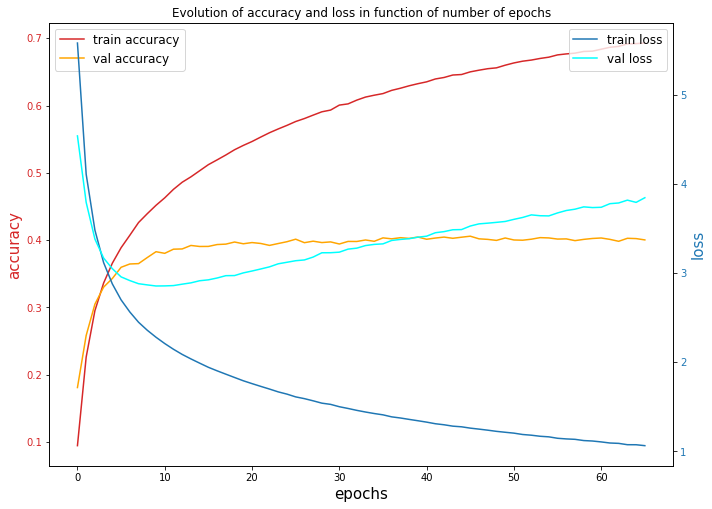

In [143]:
fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('epochs', size = 15)
ax1.set_ylabel('accuracy', color=color, size = 15)
ax1.plot(epochs, acc, color=color, label = 'train accuracy')
ax1.plot(epochs, val_acc, color='orange', label = 'val accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('loss', color=color, size = 15)  # we already handled the x-label with ax1
ax2.plot(epochs, losses, color=color, label = 'train loss')
ax2.plot(epochs, val_losses, color='cyan', label = 'val loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Evolution of accuracy and loss in function of number of epochs")
ax1.legend(prop={'size': 12})
ax2.legend(prop={'size': 12})
plt.show()

As we could have imagined, the training loss keeps decreasing while the validation loss is at its minimum at epoch 10 and then increases (model overfits on loss). However, we are more interested in the accuracy of the model to predict the correct word. We see that the training accuracy keeps increasing while the validation accuracy becomes more less constant around epoch 20 but the accuracy does not overfit.

[Go back to Neural Net](#nn)

<a id="predict"></a>

### Predict words from the test set

Once we have our trained model, we want to use it to compute predictions of words we could have in the testing set:

In [144]:
def load_all_data_for_genre(genre, tokenizer):
    """Helper function that loads all the useful data (neural net model, training history, 
    outnn_token_dict for samples trained on this genre...) for a given genre (path where the data are given)"""
    
    path_nn = 'data/NN_models/' + genre + '/' + genre + '_best_200k'
    
    # Load neural net model and history
    nn_model, training_hist = load_model(path_nn, True)
    print("Genre {} , max validation accuracy: {}".format(genre, max(training_hist['val_categorical_accuracy'])))
    
    # Load dictionary of {tokens -> output in neural net}
    token_outnn_dict = load_dict(path_nn + '/token_outnn_dict')
    outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))
    
    # Load POS files for the wanted genre
    pos_counter, word_counter, word_pos_dict = get_files_from_genre(genre)
    
    # Recreate syllables dictionnary
    syllables_dic = pyphen.Pyphen(lang = 'en')
    # pyphen dic creates new string where syllables separated by '-'
    tok_syllab_dict = {tok:len(syllables_dic.inserted(tokenizer.index_word[tok]).split('-')) for tok in token_outnn_dict.keys()}
    
    return nn_model, training_hist, token_outnn_dict, outnn_token_dict, word_pos_dict, tok_syllab_dict

In [145]:
# Load tokenizer
with open('data/NN_models/tokenizer', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load all the previously saved data useful for the wanted genre: neural net, sample words, POS of the words...
genre = 'pop'
pop_nn_model, pop_history, pop_token_outnn_dict, pop_outnn_token_dict, pop_word_pos_dict, pop_tok_syllab_dict = load_all_data_for_genre(genre, tokenizer)

# Load test files
path_nn = 'data/NN_models/' + genre + '/' + genre + '_best_200k'
test_file = path_nn + '/tests'
test = np.load(test_file + '.npz')
X_test, test_onehot_pos, test_onehot_syl, Y_test = test['array1'], test['array2'], test['array3'], test['array4']

Genre pop , max validation accuracy: 0.4058981233989692


In [146]:
def ngram_to_word(ngram, tok_word_dict):
    """
    Transform sequence of tokens to sequence of words
    """
    list_words = []
    for tok in ngram:
        if tok != 0:
            # tok == 0 -> padding at beginning
            list_words.append(tok_word_dict[tok])
    return list_words

# outnn_token_dict to map one-hot encoding prediction to the correct token
# tokenizer_index_word to map token to word
# pop_word_pos_dict to map token to part of speech

def get_predictions(nn_model, X_test, test_onehot_pos, test_onehot_syl, Y_test, batch_size, onehot_token_dict, tok_word_dict, word_pos_dict, tok_syl_dict):
    """Compute predictions of test set and display predictions compared to the real words"""
    
    predictions_onehot = nn_model.predict([X_test, test_onehot_pos, test_onehot_syl], batch_size = batch_size)
    pred_tokens = onehot_to_token(predictions_onehot, onehot_token_dict)
    
    pred_words = [tok_word_dict[tok] for tok in pred_tokens]
    real_words = [tok_word_dict[tok] for tok in Y_test]
    
    pred_pos = [word_pos_dict[w] for w in pred_words]
    real_pos = [word_pos_dict[w] for w in real_words]
    
    pred_syl = [tok_syl_dict[tok] for tok in pred_tokens]
    real_syl = [tok_syl_dict[tok] for tok in Y_test]
    
    acc_test = len([1 for i, word in enumerate(pred_words) if word == real_words[i]])/len(Y_test)
    acc_pos = len([1 for i, pos in enumerate(pred_pos) if pos == real_pos[i]])/len(Y_test)
    acc_syl = len([1 for i, syl in enumerate(pred_syl) if syl == real_syl[i]])/len(Y_test)
    
    print("Word Accuracy = {} ; POS Accuracy = {} ; Syllables Accuracy = {} \n".format(acc_test, acc_pos, acc_syl))
    
    for i, ngram in enumerate(X_test):
        seq_words = ngram_to_word(ngram, tok_word_dict)
        seq_words = ' '.join(seq_words)
        result = seq_words + ' ,' + real_words[i] + ' ----> ' + pred_words[i] + ' ( ' + real_pos[i] + ' , ' + pred_pos[i] + ' ) ; ( ' + str(real_syl[i]) + ' , ' + str(pred_syl[i]) + ' )'
        print(result)
    return pred_tokens

In [147]:
batch = 256
preds_tokens = get_predictions(pop_nn_model, X_test, test_onehot_pos, test_onehot_syl, Y_test, batch, pop_outnn_token_dict, tokenizer.index_word, pop_word_pos_dict, pop_tok_syllab_dict)


Word Accuracy = 0.40402144772117965 ; POS Accuracy = 0.998212689901698 ; Syllables Accuracy = 0.9996425379803396 

the past this is my ,second ----> private ( ADJ , ADJ ) ; ( 2 , 2 )
get messed up with you ,hello ----> alright ( INTJ , INTJ ) ; ( 2 , 2 )
whoa i whoa i ,whoa ----> yeah ( INTJ , INTJ ) ; ( 1 , 1 )
i kept you waiting for ,so ----> quite ( ADV , ADV ) ; ( 1 , 1 )
to undress it s all ,upside ----> truly ( ADV , ADV ) ; ( 2 , 2 )
own music sing your own ,special ----> grateful ( ADJ , ADJ ) ; ( 2 , 2 )
it down now voices carry ,hush ----> hush ( ADJ , ADJ ) ; ( 1 , 1 )
fills the air animals everywhere ,join ----> crank ( VERB , VERB ) ; ( 1 , 1 )
mash he did the monster ,mash ----> mash ( VERB , VERB ) ; ( 1 , 1 )
i ,may ----> woke ( VERB , VERB ) ; ( 1 , 1 )
slip away you re so ,rare ----> weird ( ADJ , ADJ ) ; ( 1 , 1 )
mountains rise standing there in ,front ----> front ( NOUN , NOUN ) ; ( 1 , 1 )
for you down down down ,karma ----> karma ( NOUN , NOUN ) ; ( 2 , 2 )
yulet

of my pay when i ,slept ----> think ( VERB , VERB ) ; ( 1 , 1 )
now didn t i and ,danced ----> liked ( VERB , VERB ) ; ( 1 , 1 )
si je chante pour toi ,tu ----> le ( ADP , ADP ) ; ( 1 , 1 )
na na na na na ,nana ----> nana ( NOUN , NOUN ) ; ( 1 , 1 )
woh oh oh oh ,woh ----> woh ( ADV , ADV ) ; ( 1 , 1 )
now we finna lose all ,self ----> strength ( NOUN , NOUN ) ; ( 1 , 1 )
the setting for nights beyond ,forgetting ----> forgetting ( VERB , VERB ) ; ( 3 , 3 )
new way tomorrows too late ,bitch ----> nights ( NOUN , NOUN ) ; ( 1 , 1 )
fine together no end forever ,instead ----> never ( ADV , ADV ) ; ( 2 , 2 )
her name without the sky ,turnin ----> stormy ( ADJ , ADJ ) ; ( 1 , 1 )
maybe tomorrow my heart will ,mend ----> mend ( VERB , VERB ) ; ( 1 , 1 )
hold the only key from ,across ----> above ( ADP , ADP ) ; ( 1 , 1 )
us is as lucky as ,us ----> him ( PRON , PRON ) ; ( 1 , 1 )
it s not about your ,jokes ----> love ( NOUN , NOUN ) ; ( 1 , 1 )
me cause i m all ,tied ----> tied ( VERB , VER

but that dont excuse the ,things ----> jokes ( NOUN , NOUN ) ; ( 1 , 1 )
round they go round and ,round ----> round ( ADV , ADV ) ; ( 1 , 1 )
can t stop this music ,traveling ----> traveling ( VERB , VERB ) ; ( 3 , 3 )
you re gone i don ,t ----> t ( NOUN , NOUN ) ; ( 1 , 1 )
unity someday somehow somewhere sometime ,somehow ----> somewhere ( ADV , ADV ) ; ( 2 , 2 )
selfish tonight i m feeling ,sexual ----> insecure ( ADJ , ADJ ) ; ( 3 , 3 )
without purity a creeping gray ,memory ----> perfection ( NOUN , NOUN ) ; ( 3 , 3 )
blow then i know you ,are ----> might ( VERB , VERB ) ; ( 1 , 1 )
out fi this watch out ,fi ----> fi ( NOUN , NOUN ) ; ( 1 , 1 )
surprised cause on all y ,all ----> no ( DET , DET ) ; ( 1 , 1 )
a rosy red anytime he ,holds ----> holds ( VERB , VERB ) ; ( 1 , 1 )
just say you ll play ,along ----> out ( ADP , ADP ) ; ( 1 , 1 )
m all strung out that ,much ----> crooked ( ADJ , ADJ ) ; ( 1 , 1 )
you move and rock it ,til ----> twice ( ADV , ADV ) ; ( 1 , 1 )
gotta eat to

just a matter of time ,bridge ----> tryin ( NOUN , NOUN ) ; ( 1 , 1 )
i have sensed it all ,along ----> along ( ADP , ADP ) ; ( 1 , 1 )
i get it on i ,got ----> kno ( VERB , VERB ) ; ( 1 , 1 )
sei oh darling dimmi con ,chi ----> con ( NOUN , NOUN ) ; ( 1 , 1 )
the world and ill be ,thinking ----> stealing ( VERB , VERB ) ; ( 2 , 2 )
curtain opened heard the crowd ,roar ----> goes ( VERB , VERB ) ; ( 1 , 1 )
to be well i m ,half ----> half ( ADJ , ADJ ) ; ( 1 , 1 )
alert but i can t ,resist ----> escape ( VERB , VERB ) ; ( 2 , 2 )
s so hard to handle ,sooner ----> somehow ( ADV , ADV ) ; ( 2 , 2 )
empty home she s still ,comfortable ----> satisfied ( ADJ , ADJ ) ; ( 3 , 3 )
sits on the front porch ,swinging ----> looking ( VERB , VERB ) ; ( 2 , 2 )
this is what you re ,missing ----> needing ( VERB , VERB ) ; ( 2 , 2 )
got the right to remain ,right ----> once ( ADV , ADV ) ; ( 1 , 1 )
it makes me furious but ,if ----> whether ( ADP , ADP ) ; ( 1 , 1 )
know it takes more than ,strength -

to change you better stand ,aside ----> alone ( ADV , ADV ) ; ( 1 , 1 )
won t you come and ,rescue ----> rescue ( VERB , VERB ) ; ( 2 , 2 )
all alone as i went ,along ----> thru ( ADP , ADP ) ; ( 1 , 1 )
you ain t never ever ,ever ----> ever ( ADV , ADV ) ; ( 2 , 2 )
layin side by side you ,could ----> smiled ( VERB , VERB ) ; ( 1 , 1 )
watching me yeah watching you ,watching ----> watching ( VERB , VERB ) ; ( 2 , 2 )
i m curious i m ,curious ----> curious ( ADJ , ADJ ) ; ( 3 , 3 )
i m not thinking too ,clearly ----> often ( ADV , ADV ) ; ( 2 , 2 )
oh baby ready or not ,express ----> express ( VERB , VERB ) ; ( 2 , 2 )
it sings about filled with ,empty ----> empty ( ADJ , ADJ ) ; ( 2 , 2 )
tumble to the ground and ,then ----> forth ( ADV , ADV ) ; ( 1 , 1 )
it in the cold and ,watched ----> slip ( VERB , VERB ) ; ( 1 , 1 )
search in circles for a ,remedy ----> photograph ( NOUN , NOUN ) ; ( 3 , 3 )
we re live again from ,usa ----> april ( NOUN , NOUN ) ; ( 1 , 1 )
wild golliwog oooh th

what can you lose pretending ,spending ----> saving ( VERB , VERB ) ; ( 2 , 2 )
me stronger you re no ,longer ----> longer ( ADV , ADV ) ; ( 1 , 1 )
wanna see ya wit cha ,hair ----> tongue ( NOUN , NOUN ) ; ( 1 , 1 )
i signed my name and ,sold ----> turned ( VERB , VERB ) ; ( 1 , 1 )
aaah yeah i keep fallin ,fallin ----> fallin ( NOUN , NOUN ) ; ( 1 , 1 )
the list is the list ,of ----> of ( ADP , ADP ) ; ( 1 , 1 )
you ,sold ----> went ( VERB , VERB ) ; ( 1 , 1 )
phresh out phresh out the ,runway ----> runway ( NOUN , NOUN ) ; ( 2 , 2 )
just rock on up they ,ll ----> said ( VERB , VERB ) ; ( 1 , 1 )
go whatever you may do ,know ----> don ( VERB , VERB ) ; ( 1 , 1 )
re mine so use me ,don ----> tell ( VERB , VERB ) ; ( 1 , 1 )
where s that lining they ,cheer ----> doubts ( NOUN , NOUN ) ; ( 1 , 1 )
and watch the world down ,below ----> below ( ADP , ADP ) ; ( 2 , 2 )
coo sa mama se mama ,sa ----> sa ( ADP , ADP ) ; ( 1 , 1 )
that fell my gift my ,gift ----> gift ( NOUN , NOUN ) ; ( 1 , 1

For the pop genre, the accuracy of predicting the exact same word from the testing set is <b>40 %</b> which is quite good because the neural network predicts one output over more than a thousand. The accuracy is the same as with the validation set in the neural network which is normal. The correct POS prediction is <b>99 %</b> as well as for the syllables accuracy. The results for the other genres is given below:

In [148]:
# Accuracies given from the test data
info_dict = {'pop':[0.4040, 0.9982, 0.9996], 'rock':[0.3174, 0.9819, 0.9996], 'metal':[0.2579, 0.9620, 0.9993], 'jazz':[0.4690, 0.9738, 0.9989], 'country':[0.3781, 0.9751, 0.9994], 'hiphop':[0.2512, 0.9216, 0.9997]}
info_df = pd.DataFrame.from_dict(info_dict)
info_df.rename(index = {0:'accuracy word', 1:'accuracy POS', 2:'accuracy syllables'})

,pop,rock,metal,jazz,country,hiphop
accuracy word,0.4040,0.3174,0.2579,0.4690,0.3781,0.2512
accuracy POS,0.9982,0.9819,0.9620,0.9738,0.9751,0.9216
accuracy syllables,0.9996,0.9996,0.9993,0.9989,0.9994,0.9997


[Go back to Neural Net](#nn)

<a id="lyricsgen"></a>

### Lyrics Generation for a specific genre

We first need to predict what would be the next Parts Of Speech based on the one of the last word we have. We already computed all the necessary probabilities for prediction [previously](#pos).

In [63]:
pos_counts = pickle.load(open("data/NN_models/pos_counts.p", "rb" ))
pos2idx = pickle.load(open("data/NN_models/pos2idx.p", "rb"))
pos_to_keep = {'INTJ','NOUN','ADV','PRON','VERB','ADP','DET','CCONJ','ADJ','NUM','PROPN'} 

def predict_next_pos(curr_pos):
    prob = pos_counts[pos2idx[curr_pos]]
    next_pos = ''
    while next_pos not in pos_to_keep:
        # Only predict a POS in the set that we trained on
        next_pos = np.random.choice(list(prob.keys()), p=list(prob.values()))
    return next_pos

predict_next_pos('NOUN')

'CCONJ'

In [64]:
# word_pos_dict = pop_word_pos_dict
# pos_index_dict
# syl_index_dict
# onehot_token_dict = outnn_token_dict
def generate_lyrics(nn_model, init_string, tokenizer, word_pos_dict, pos_index_dict, onehot_token_dict, words_to_generate = 20):
    """Function that generates lyrics by taking an initial string and predicts the next words by feeding input in the neural network"""
    # Convert string to list of tokens:
    init_list_words = init_string.split(' ')[-(n - 1):]
    init_list_tokens = [tokenizer.word_index[w] for w in init_list_words]
    
    # Get POS of last word:
    last_pos = [word_pos_dict[w] for w in init_list_words][-1]
    
    # Generate next tokens with the neural network
    tokens_list = init_list_tokens.copy()
    list_pos = []
    for i in range(words_to_generate):
        input_tokens = tokens_list[i:]
        
        pos_to_predict = predict_next_pos(last_pos)
        _, input_pos = token_to_onehot([pos_to_predict], pos_index_dict)
        # Syllables has no importance for generation of next words, if you want word with specific number of syllable, change next line
        input_syl = [0.0, 0.0, 0.0, 0.0]
        
        pred_onehot = nn_model.predict([[input_tokens], input_pos, [input_syl]])
        pred_token = onehot_to_token(pred_onehot, onehot_token_dict)
        real_pos = word_pos_dict[tokenizer.index_word[pred_token[0]]]
        
        tokens_list.append(pred_token[0])
        list_pos.append((pos_to_predict, real_pos))
        last_pos = real_pos
        
    
    # Convert tokens into a phrase
    list_words = ngram_to_word(tokens_list, tokenizer.index_word)
    sentence = ' '.join(list_words)
    print("Part of Speech (expected, predicted) ---> {} \n".format(list_pos))
    return sentence

In [65]:
initial = 'i m in love with'
generated_lyrs = generate_lyrics(pop_nn_model, initial, tokenizer, pop_word_pos_dict, pos_index_dict, pop_outnn_token_dict, words_to_generate = 40)
print(generated_lyrs)

Part of Speech (expected, predicted) ---> [('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'ADJ'), ('VERB', 'ADJ'), ('NOUN', 'NOUN'), ('VERB', 'VERB'), ('PRON', 'ADJ'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('PRON', 'PRON'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('CCONJ', 'CCONJ'), ('VERB', 'VERB'), ('DET', 'DET'), ('ADJ', 'ADJ')] 

i m in love with every minute underneath yah satisfy it satisfy underneath yah underneath another cloud we appreciate ourselves worship everlasting everlasting joy worship everlasting inspiration underneath itself traveling another mountain underneath another tree

We can see that this lyrics generations sometimes has not much sense and it can predict the same word again and again. The generation could have been better by predicting the next POS not only on the POS of the last word but on the POS of the 2 or 3 last words.

[Go back to Neural Net](#nn)

<a id="fusion"></a>

### Convert lyrics from one genre to another one

Let's check the lyrics we can get from one genre: pop for instance to the other genres

In [149]:
# Pick a pop song that has some interesting words that we could change
pop_song = list_lyrs_pop[5600]
print(' '.join(pop_song) + '\n')

pos_index_dict = load_dict('data/NN_models/POS_index_dict')
syl_index_dict = load_dict('data/NN_models/syllables_index_dict')
n = 6 # for ngrams: size of tokens input of neural network, typically 6

syllables_dic = pyphen.Pyphen(lang = 'en')
# pyphen dic creates new string where syllables separated by '-'
tok_syllab_dict = {tok:len(syllables_dic.inserted(tokenizer.index_word[tok]).split('-')) for tok in token_outnn_dict.keys()}

check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin doors 245 n pullin the keys now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed stealing from the spot that i truly chosed i lose and my choice to chose now i m fix and i m fallin deeper in the mix there s no hope for me see my path has been chosen i m johnny be chorus johnny behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh johnny be chorus the situation s tight you are billin by the night can t choose between the wrongs and the rights i m searchin for the clues yowhat am i gotta do i got the habit to take valuable things from you here i stand and i 

In [150]:
# Get the words that we would like to change and get the inputs to feed the neural network
def get_words_to_change(lyrics, genre_typical_words, genre_word_pos_dict, amount = 10):
    """
    Function that gets the most common words in the lyrics given a sorted list for a specific genre
    lyrics: list of strings (the lyrics of a song)
    genre_typical_words: the sorted list of typical words of a genre (pop_diff_list for pop), format: tuples (word, diff_count)
    amount: the number of words we want to change in the lyrics
    """
    words_to_change = []
    words_to_change_pos = []
    found_words = 0 
    for w, _ in genre_typical_words:
        if w in lyrics:
            words_to_change.append(w)
            words_to_change_pos.append([(word, i) for i, word in enumerate(lyrics) if word == w])
            found_words += 1
        if found_words == amount:
            break
    print("List of words to change in the lyrics: {}".format(words_to_change))
    words_to_change_pos = [w for l in words_to_change_pos for w in l]
    words_to_change_pos = sorted(words_to_change_pos, key = lambda x: x[1])
    
    tokens_to_change = [tokenizer.word_index[w] for w in words_to_change]
    lyrics_tokens = (n - 1) * [0] + [tokenizer.word_index[w] for w in lyrics] # Append 0 tokens at beginning in case of 
    
    # Get the tokens ngrams for sentences before the tokens to change (input of the neural net)
    ngrams_with_output = np.array(ngram_lyrics(n, lyrics_tokens, samples_tokens = tokens_to_change))
    input_ngrams = ngrams_with_output[:,:-1]
    output = ngrams_with_output[:,-1]
    
    # Get the POS of tokens that we want to predict
    tok_pos_dict = {tokenizer.word_index[w] : genre_word_pos_dict[w] for w in words_to_change}
    _, input_onehot_pos = token_to_onehot(output, pos_index_dict, tok_pos_dict)
    
    # Get the #syllables of tokens that we want to predict
    tok_syllab_dict = {tokenizer.word_index[w]:len(syllables_dic.inserted(w).split('-')) for w in words_to_change}
    _, input_onehot_syl = token_to_onehot(output, syl_index_dict, tok_syllab_dict)
    
    nn_input = [input_ngrams, input_onehot_pos, input_onehot_syl]
    return nn_input, output

pop_nn_input, pop_output = get_words_to_change(pop_song, pop_diff_list, pop_word_pos_dict, amount = 25)

List of words to change in the lyrics: ['sleepless', 'frightened', 'stealing', 'searchin', 'habit', 'rights', 'spirits', 'drifting', 'chose', 'chosen', 'truly', 'situation', 'johnny', 'certain', 'mix', 'fallin', 'keys', 'deeper', 'callin', 'fix', 'calls', 'repeat', 'trapped', 'breeze', 'doors']


In [157]:
def predict_new_words(g2_nn_model, g1_nn_input, outputs_tokens, g2_outnn_token_dict):
    """
    Given neural network of other genre (g2) and input of genre 1 (g1) from the song, 
    compute the prediction from g1 to g2 
    """
    predictions_onehot = g2_nn_model.predict(g1_nn_input)
    pred_tokens = onehot_to_token(predictions_onehot, g2_outnn_token_dict)
    
    pred_words = [tokenizer.index_word[tok] for tok in pred_tokens]
    real_words = [tokenizer.index_word[tok] for tok in outputs_tokens]
    
    return list(zip(real_words, pred_words))

BOLD_BEG = '\033[1m'
BOLD_END = '\033[0m'

def get_new_lyrics(lyrics, real_pred_list):
    """
    Function that gives the new lyrics based on predictions generated from the other genre
    real_pred_list: sorted list of apparition of tuples: (real word, predicted word)
    """
    # real_pred_list sorted in order of apparition
    new_lyrics = []
    idx = 0
    for w in lyrics:
        if idx < len(real_pred_list):
            real_w, pred_w = real_pred_list[idx]
        if w == real_w:
            new_lyrics.append(BOLD_BEG + pred_w + BOLD_END)
            idx += 1
        else:
            new_lyrics.append(w)
    print("Converted lyrics:")
    print(' '.join(new_lyrics) + '\n')
    return new_lyrics
    

Predict to metal genre:

In [152]:
genre = 'metal'
metal_nn_model, _, _, metal_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre metal , max validation accuracy: 0.26767676764392767


In [158]:
metal_preds_list = predict_new_words(metal_nn_model, pop_nn_input, pop_output, metal_outnn_token_dict)
metal_pop_lyrs = get_new_lyrics(pop_song, metal_preds_list)

print(metal_preds_list)

Converted lyrics:
check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin wit 245 n pullin the road now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed revealed from the spot that i nigga chosed i lose and my choice to sell now i m telling and i m comin little in the abyss there s no hope for me see my path has been unleashed i m centuries be chorus chorus behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh chorus be chorus the infinity s tight you are billin by the night can t choose between the wrongs and the anger i m free for the clues yowhat am i gotta do i got the rules to take valuable things from you

Predict to rock genre:

In [159]:
genre = 'rock'
rock_nn_model, _, _, rock_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre rock , max validation accuracy: 0.3194070080541215


In [160]:
rock_preds_list = predict_new_words(rock_nn_model, pop_nn_input, pop_output, rock_outnn_token_dict)
rock_pop_lyrs = get_new_lyrics(pop_song, rock_preds_list)

print(rock_preds_list)

Converted lyrics:
check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin tin 245 n pullin the pony now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed covered from the spot that i simply chosed i lose and my choice to speak now i m strung and i m talkin jenny in the tides there s no hope for me see my path has been taken i m nothing be chorus brother behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh motel be chorus the revolution s tight you are billin by the night can t choose between the wrongs and the knives i m amazed for the clues yowhat am i gotta do i got the key to take valuable things from you he

Predict to jazz genre:

In [161]:
genre = 'jazz'
jazz_nn_model, _, _, jazz_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre jazz , max validation accuracy: 0.4808471452684912


In [162]:
jazz_preds_list = predict_new_words(jazz_nn_model, pop_nn_input, pop_output, jazz_outnn_token_dict)
jazz_pop_lyrs = get_new_lyrics(pop_song, jazz_preds_list)

print(jazz_preds_list)

Converted lyrics:
check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin jack 245 n pullin the bass now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed destroy from the spot that i never chosed i lose and my choice to fight now i m tied and i m shakin deeper in the wind there s no hope for me see my path has been covered i m longing be chorus johnny behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh doggone be chorus the mississippi s tight you are billin by the night can t choose between the wrongs and the years i m guilty for the clues yowhat am i gotta do i got the st to take valuable things from you he

Predict to country genre:

In [163]:
genre = 'country'
country_nn_model, _, _, country_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre country , max validation accuracy: 0.3879162702358529


In [164]:
country_preds_list = predict_new_words(country_nn_model, pop_nn_input, pop_output, country_outnn_token_dict)
country_pop_lyrs = get_new_lyrics(pop_song, country_preds_list)

print(country_preds_list)

Converted lyrics:
check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin porch 245 n pullin the boots now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed cover from the spot that i already chosed i lose and my choice to cut now i m knowin and i m losin deeper in the rain there s no hope for me see my path has been begun i m travelin be chorus johnny behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh sweetheart be chorus the mississippi s tight you are billin by the night can t choose between the wrongs and the roads i m afraid for the clues yowhat am i gotta do i got the news to take valuable things from y

Predict to hip hop genre:

In [165]:
genre = 'hiphop'
hip_nn_model, _, _, hip_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre hiphop , max validation accuracy: 0.2541998231284498


In [166]:
hip_preds_list = predict_new_words(hip_nn_model, pop_nn_input, pop_output, hip_outnn_token_dict)
hip_pop_lyrs = get_new_lyrics(pop_song, hip_preds_list)

print(hip_preds_list)

Converted lyrics:
check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin cats 245 n pullin the keys now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed approach from the spot that i hardly chosed i lose and my choice to float now i m bringin and i m bustin lower in the joint there s no hope for me see my path has been written i m thuggin be chorus busta behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh sippin be chorus the motherfucker s tight you are billin by the night can t choose between the wrongs and the homies i m catchin for the clues yowhat am i gotta do i got the cheese to take valuable things f

[Go to top](#top)

<a id="webpage"></a>

## Webpage

In order to enjoy our webpage demo, the files required to have a user-friendly loading time depend on which demo you'd like. For the Neural Network, all files are computed in the data zip. For MUSE, we have computed only 4 pairs of genre: rock -> pop, pop -> rock, rock -> hip hop and pop -> metal. However you can make the computations for any other pair with the MUSE file creation notebook.<br>

To launch the demo, in a terminal:
- Go to the <b>webpage</b> folder
- Run the following command line: <b> python3 run_demo.py </b>
- Open your internet browser and go to : <b> localhost:5000 </b>

You should discover the following webpage:

![title](img/homepage.png)

For both approaches, you have to provide the following parameters:
- Select the number of words you would like to swap
- Select your source genre
- Pick one of the pre-selected songs
- Select your target genre
- Click start!

![title](img/params_filled.png)

You can now pick the approach of your choice to predict.

![title](img/buttons.png)

You can expect to see this result with MUSE!

![title](img/muse_result.png)

You can expect to see this result with the Neural Net!

![title](img/nn_result.png)

[Go to top](#top)

<a id="ccl"></a>

## Conclusion

Among the weeks of this project, we encountered multiple challenges and had to make some decisions in order to get as close as possible to our initial goal. If we finally developed two different approaches to mix two musical genres, we are aware that the prediction and complete fusion are not fully operational yet. We will list below different points that could benefit from extra work or thoughts.

Our first difficulty, which revealed itself to be very time consuming, was to get a significant collection of clean lyrics. We already mentionned the issue of the legal protection provided by Intellectual Property, preventing open source lyrics dataset online. This said, the lyrics websites very often rely on human and community participation to transcribe the lyrics. This inevitably implies that the lyrics scrapped from those websites will present many typos or specificities due to the lyrics format (ie, the multiplication of characters to imply some singing effects as "yyyyyyou"). We believe that a greater quality of results could be obtained if the lyrics were perfectly cleaned of those artefacts.

Then, our second issue was to filter by language. Even with the great help of the <b>detect</b> library, we realized that some verses of songs could be in different languages. This again makes the dataset imperfect as encoding different languages with the same embedding seems conceptually wrong, as the similarity of words among different language is not relevant here.

One other point is the genre classification. It is commonly known that even music experts are not always agreeing on every genre classification and we also spotted some artists uncorrectly classified in the initial dataset (e.g. rock artists classified as pop). This said, we could select songs acknowledged as clear representatives of the musical genres chosen. This would require some additional work and could reduce drastically the size of the dataset, as such songs could be rare.

Following this thought, we note that our strategy to attribute one main genre to an artist is not optimal. Indeed one artist could explore diversity and have songs with specific characteristics from another genre. We could refine the genre classification and label each song independently. This could be a standalone project.

As an attempt to adress the two previous points, we made the decisions to explore only six main genres. This level of granularity could be discussed and improved. One must keep in mind that increasing the refinement of genres will reduce the number of potential songs belonging to this genre and make the genre classification more complicated. This is a trade-off.

We also found that the <b>Fasttext</b> library does not compute embeddings for each word from the vocabulary: sometimes it computes embeddings for non-meaningful words but not for grammatically correct english words (e.g. rework was in the lyrics but missing from FastText embeddings). Even though the majority of meaningful words had an embedding, this issue could affect the word predictions as we had to remove the words with no corresponding embeddings from the lyrics. If the reader has the time and patience, we provided the code in this notebook to compute the embeddings of the missing words.

Concerning the related projects given as litterature at the begining of the notebook, we note that they generally explore smaller and more focused dataset. The datasets are either focused on one given artist or one specific music genre. One advantage is that the cleaning is easier. We also note the use of websites to gather the datasets. 

Nevertheless, we found the project to be really interesting and managed to identify a few promising examples, shown in this notebook or the demo. 

As a final word, we would state that this project is indeed a genuine Data Science Project: we spent 80% of our efforts gathering and cleaning data, while we wanted to play more with the neural network 😉

[Go to top](#top)